In [1]:
from collections import Counter
from collections import defaultdict
import glob
import itertools
from itertools import izip
import os

from IPython.core.display import HTML, Image
from matplotlib import gridspec
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scipy
from scipy.stats import linregress
from scipy.stats import ks_2samp
import seaborn as sns
import statsmodels as sm

from clipper.src import get_genomic_regions
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts import GO
from gscripts import miso

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/gp_figures"
%matplotlib inline

In [2]:
!mkdir -p /nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/
!scp -q tscc-login.sdsc.edu:~/projects/fet_family/analysis/rna_stabality_v3/*.{metrics,final.out,txt} /nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/

In [3]:
color_map = {"fus": '#43A247',
             "FUS": '#43A247',
             'taf15': '#DB1D3D',
             'TAF15': '#DB1D3D',
             'tdp43': '#712878',
             'TDP43': '#712878',
             'fus_taf15': 'c',
             'taf15_tdp43': 'c',
             'EWS' : 'g',
             'ctrl': (0.90311419262605563, 0.54185316071790801, 0.76495195557089413)}

#colors = sns.color_palette("Set2", 4)
#rbps = ["TAF15", "FUS", "EWS", "ctrl"]
#rbp_colors = dict(zip(rbps, colors))

In [4]:
%load_ext autoreload 
%autoreload 2
reload(dataviz)
reload(GO)

<module 'gscripts.GO' from '/nas3/gpratt/anaconda/lib/python2.7/site-packages/gscripts-0.1.6-py2.7.egg/gscripts/GO/__init__.pyc'>

In [5]:
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]
        
def move_name(interval):
    interval.name = interval[12]
    return interval

In [6]:
gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")
name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

gencode_to_ensembl_dict = dict(izip(gene_id_to_name.keys(), gencode_to_ensembl(gene_id_to_name.keys())))
ensembl_to_gencode = {value: key for key, value in gencode_to_ensembl_dict.items()}


#Basic QC

In [7]:
analysis_dir = "/nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/"
fet_clip = parsers.rnaseq_metrics(analysis_dir)

filtered_guttman_clip = fet_clip[[ "Input Reads",
                            #"Reads After Triming",
                                "Percent Repetative",
                             "repetitive_count",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",

                            ]]

HTML(filtered_guttman_clip.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "repetitive_count" : parsers.commas,

                                     } ))

Conclusions
---
RNA-seq was tru-seq stranded kit with ribo-zero gold before hand to remove repetitive elements

RNA-seq is very shakey, highly different numbers of reads sequenced and repetitive elements removed.  This is partally because of ribo-seq gold treament (hopefully).  Long story short we can't use this data as a gold standard for anything, but we might be able to find targets

In [8]:
mapper = {"NPC0": 0,
"NPC15": 15,
"NPC1": 60,
"NPC30": 30,
"NPC2": 120,
"NPC4": 4 * 60}

new_index = []
for item in fet_clip.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])
    
fet_clip.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
fet_clip = fet_clip.sort_index()

In [9]:
mapped_counts = pd.Series({"NPC0_ctrl": 22.5,
"NPC0_EWS": 65.8,                   
"NPC0_FUS": 39.4,                         
"NPC0_TAF15": 64.9,                          
"NPC15_ctrl":  56.4,                        
"NPC15_EWS": 66.4,                     
"NPC15_FUS":   29.3,                          
"NPC15_TAF15": 61.3,                         
"NPC1_ctrl":  65.7,                        
"NPC1_EWS":   67.7,                         
"NPC1_FUS":  63.5,                       
"NPC1_TAF15": 61.0,
"NPC2_ctrl":  22.3,                          
"NPC2_EWS":    64.6,                          
"NPC2_FUS":  62.3,                      
"NPC2_TAF15": 56.2,                        
"NPC30_ctrl": 56.7,                        
"NPC30_EWS": 67.4,                      
"NPC30_FUS": 44.5,                        
"NPC30_FUS": 44.5,                        
"NPC30_TAF15": 66.1,                        
"NPC4_ctrl": 19.3,                        
"NPC4_EWS": 62.4,                        
"NPC4_FUS": 56.1,                    
"NPC4_TAF15": 31.2,})                

new_index = []
for item in mapped_counts.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])
    
mapped_counts.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
mapped_counts = mapped_counts.sort_index()

#Digging into Lack of Uniform Processing

/nas3/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1
/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


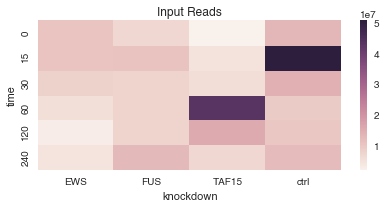

In [10]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fet_clip['Input Reads'].unstack().astype(float), ax=ax)
    ax.set_title("Input Reads")

Figure Legend: Heatmap of numbers of input reads, x axis is knockdown and y axis is time (in min)

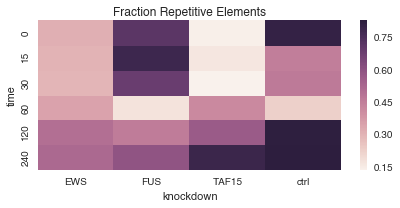

In [11]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fet_clip['Percent Repetative'].unstack().astype(float), ax=ax)
    ax.set_title("Fraction Repetitive Elements")

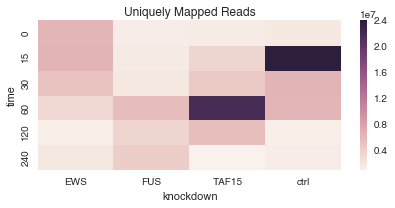

In [12]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fet_clip['Uniquely Mapped Reads'].unstack().astype(float), ax=ax)
    ax.set_title("Uniquely Mapped Reads")

Figure Legend: Heatmap of Fraction of repetitive elements, x axis is knockdown and y axis is time (in min)

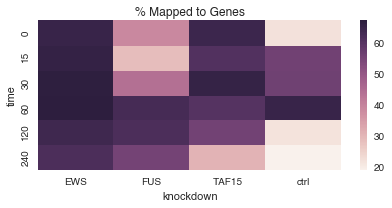

In [13]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(mapped_counts.unstack().astype(float), ax=ax)
    ax.set_title("% Mapped to Genes")

Figure Legend: Heatmap of percent of reads mapped to genes, x axis is knockdown and y axis is time (in min)

Concluiosns
---

1. Number of input reads is highly varible
2. Number of % mapped to genes is inversely correlated to % of reads removed by repetitive elements.  This is because my rmRep Script isn't perfect and small differenes will not be observed / counted.


#Check knockdowns

In [14]:
def counts_to_rpkm(featureCountsTable):
    counts = featureCountsTable.ix[:,5:]
    lengths = featureCountsTable['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)


In [192]:
#MN
stabality_counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/all_counts.txt", skiprows=1, index_col=0)
stabality_counts.columns = [os.path.basename(item).split(".")[0] for item in stabality_counts.columns]
stabality_rpkm = counts_to_rpkm(stabality_counts).T

mapper = {"NPC0": 0,
"NPC15": 15,
"NPC1": 60,
"NPC30": 30,
"NPC2": 120,
"NPC4": 4 * 60}

new_index = []
for item in stabality_rpkm.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])

stabality_rpkm.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
stabality_rpkm = stabality_rpkm.sort_index()
stabality_rpkm.columns.name = "gene"

In [196]:
for col in stabality_counts[stabality_counts.columns[5:]]:
    pd.DataFrame(stabality_counts[col]).to_csv("/nas3/gpratt/Dropbox/TAF15/geo/human/stabality/{}.csv".format(col))

In [16]:
qc_columns = stabality_rpkm[[name_to_gene_id['TAF15'], 
                name_to_gene_id['FUS'],
                            name_to_gene_id['EWSR1']]]

qc_columns.columns = [gene_id_to_name[item] for item in qc_columns.columns]

Conclusions
---

knockdown appeared to work (for the most part), will want to check how many genes actually show global decay, relative to genes with long halflives

#Unnormalized half-lives for RPKMs, to see if time series analysis might work

RLP27, RLP13

In [17]:
stabality_rpkm_log = np.log(stabality_rpkm)

#Double check that my math is correct

In [18]:
def decay_rate(n0, t, decay_rate=.5):
    return n0 * np.exp(-1 * decay_rate * t)

def halflife_rate(n0, t, halflife=.5):
    return n0 * np.exp(halflife * t)


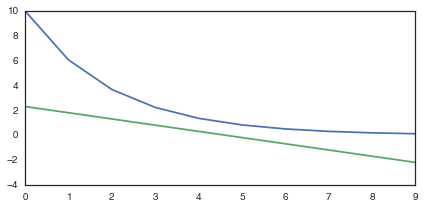

In [19]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    foo = [decay_rate(10, time) for time in np.arange(0,10)]
    ax.plot(foo)
    ax.plot(np.log(foo))

In [20]:
linregress(np.arange(0,10), np.log(foo))

LinregressResult(slope=-0.5, intercept=2.3025850929940459, rvalue=-1.0, pvalue=4.375000000000076e-80, stderr=0.0)

The halflife is .5 so I'm making a proper roundtrip, linregress / my model is correct.  

Double check my hand made results vs computed results
---

Woops deleted that check, but it works, trust me future gabe

In [21]:
def calculate_half_lives(df):
    values = ["slope", "intercept", "r-value", "p-value", "stderr"]

    results = {}
    for knockdown, df in df.groupby(level=["knockdown"]):
        df[np.isneginf(df) | np.isinf(df)] = np.nan
        df = df.dropna(axis=1)
        result = {}
        for index in df.columns:
            regression = linregress(df.index.get_level_values(level="time"), df[index])
            result[index] = dict(zip(values, regression))
        result = pd.DataFrame(result).T
        results[knockdown] = result
    half_lives = pd.concat(results, names=['knockdown', 'gene'])
    #Think about making this a bit more robust, maybe doing fitting if all contigous values are there or something
    #Calculate other stuffs
    half_lives['r2'] = half_lives['r-value']**2
    half_lives['decay'] = half_lives['slope'] * -1
    half_lives['halflife'] = half_lives.decay.apply(lambda x: np.log(2) / x)
    return half_lives

def shuffle(df, n=1, axis=0):     
    df = df.copy()
    axis = int(not axis) # pandas.DataFrame is always 2D
    for _ in range(n):
        for view in np.rollaxis(df.values, axis):
            np.random.shuffle(view)
    return df

#old shuffle, randomly started breaking
# def shuffle(df, n=1, axis=0):   
#     #Shuffles df by columns or rows
#     df = df.copy()
#     for _ in range(n):
#         df.apply(np.random.shuffle, axis=axis)
#     return df

def shuffle_stabality_df(stabality_df, axis=0):
    #shuffles multi-index by columns or rows given groupby statement
    result = {}
    for name, df in stabality_df.groupby(level="knockdown"):
        result[name] = shuffle(df, axis=0)
    result = pd.concat(result)
    return result



In [22]:
half_lives = calculate_half_lives(stabality_rpkm_log)
shuffled_half_lives = calculate_half_lives(shuffle_stabality_df(stabality_rpkm_log))

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nas3/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.where(-key, value, inplace=True)


Drop timepoint 0, apparently its worse...

In [23]:
trimmed_stabality_rpkm_log = stabality_rpkm_log.drop(0, level="time")

trimmed_half_lives = calculate_half_lives(trimmed_stabality_rpkm_log)
trimmed_shuffled_half_lives = calculate_half_lives(shuffle_stabality_df(trimmed_stabality_rpkm_log))


/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
trimmed_shuffled_half_lives_by_timepoint = calculate_half_lives(shuffle_stabality_df(trimmed_stabality_rpkm_log, axis=1))


/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
all_halflives = pd.concat({"half_lives": half_lives,
                           "shuffled_half_lives": shuffled_half_lives,
                           "trimmed_half_lives": trimmed_half_lives,
                           "trimmed_shuffled_half_lives": trimmed_shuffled_half_lives,
                           "trimmed_shuffled_half_lives_by_timepoint": trimmed_shuffled_half_lives_by_timepoint}, names=['exp', 'knockdown', 'gene'])

Plot Decay Rate for all samples

In [26]:
good_halflives = all_halflives[all_halflives.decay > 0]

In [27]:
all_halflives.groupby(level=['exp', 'knockdown']).count().intercept.unstack()

knockdown                                   EWS    FUS  TAF15   ctrl
exp                                                                 
half_lives                                16663  15420  15989  14189
shuffled_half_lives                       16663  15420  15989  14189
trimmed_half_lives                        16690  16032  16415  14674
trimmed_shuffled_half_lives               16690  16032  16415  14674
trimmed_shuffled_half_lives_by_timepoint  16690  16032  16415  14674

Check R2 for things thrown out

In [28]:
good_halflives.groupby(level=['exp', 'knockdown']).count().intercept.unstack()

knockdown                                  EWS   FUS  TAF15  ctrl
exp                                                              
half_lives                                9023  8322   8837  8277
shuffled_half_lives                       8122  7502   7691  6912
trimmed_half_lives                        9128  8889   8947  8585
trimmed_shuffled_half_lives               8073  7832   8051  7055
trimmed_shuffled_half_lives_by_timepoint  8140  7676   7923  7121

#Try different scrambling methods

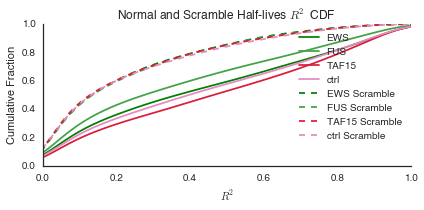

In [29]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    for name, df in good_halflives.ix['half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color_map[name], ax=ax)
    
    for name, df in good_halflives.ix['shuffled_half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name+ " Scramble", linestyle="--", color=color_map[name], ax=ax)
    
    ax.set_xlim(0,1)
    sns.despine(ax=ax)
    ax.set_title("Normal and Scramble Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    ax.legend()

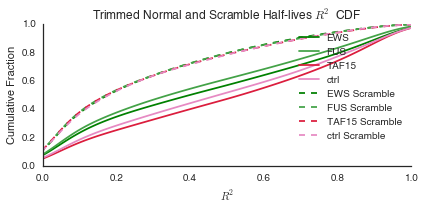

In [30]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    for name, df in good_halflives.ix['trimmed_half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color_map[name], ax=ax)
    
    for name, df in good_halflives.ix['trimmed_shuffled_half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name + " Scramble", linestyle="--", color=color_map[name], ax=ax)
    
    ax.set_xlim(0,1)
    ax.set_title("Trimmed Normal and Scramble Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    sns.despine(ax=ax)
    ax.legend()

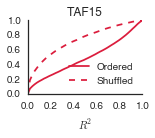

In [31]:
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "taf15_halflife_validation.svg"), figsize=(num_cols * 2, num_rows * 2.0)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,2)
    dataviz.plot_cdf(good_halflives.ix['trimmed_half_lives', 'TAF15'].r2, label="Ordered", color=color_map['TAF15'], ax=ax)
    dataviz.plot_cdf(good_halflives.ix['trimmed_shuffled_half_lives', 'TAF15'].r2, label="Shuffled", linestyle="--", color=color_map['TAF15'], ax=ax)
    ax.set_xlim(0,1)
    ax.set_title("TAF15")
    ax.set_xlabel("$R^2$")
    #ax.set_ylabel("Cumulative Fraction")
    #ax.set_yticks([])
    sns.despine(ax=ax)
    ax.legend(loc=0)

In [32]:
print np.median(good_halflives.ix['trimmed_half_lives', 'TAF15'].r2), np.median(good_halflives.ix['trimmed_shuffled_half_lives', 'TAF15'].r2)

0.540203012239 0.1685871452


In [33]:
#KS test
scipy.stats.ks_2samp(good_halflives.ix['trimmed_half_lives', 'TAF15'].r2, good_halflives.ix['trimmed_shuffled_half_lives', 'TAF15'].r2)

Ks_2sampResult(statistic=0.32031996702812354, pvalue=0.0)

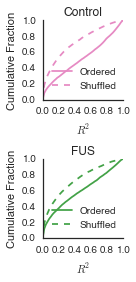

In [34]:
num_rows = 2
num_cols = 1
#with sns.set_style("ticks"):
with dataviz.Figure(os.path.join(img_dir, "halflife_validation.svg"), figsize=(num_cols * 2, num_rows * 2.0)) as fig:
    
    ax = fig.add_subplot(num_rows,num_cols,1)
    dataviz.plot_cdf(good_halflives.ix['trimmed_half_lives', 'ctrl'].r2, label="Ordered", color=color_map['ctrl'], ax=ax)
    dataviz.plot_cdf(good_halflives.ix['trimmed_shuffled_half_lives', 'ctrl'].r2, label="Shuffled", linestyle="--", color=color_map['ctrl'], ax=ax)
    ax.set_xlim(0,1)
    ax.set_title("Control")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    sns.despine(ax=ax)
    ax.legend(loc=0)

    ax = fig.add_subplot(num_rows,num_cols,2)
    dataviz.plot_cdf(good_halflives.ix['trimmed_half_lives', 'FUS'].r2, label="Ordered", color=color_map['FUS'], ax=ax)
    dataviz.plot_cdf(good_halflives.ix['trimmed_shuffled_half_lives', 'FUS'].r2, label="Shuffled", linestyle="--", color=color_map['FUS'], ax=ax)
    ax.set_xlim(0,1)
    ax.set_title("FUS")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    #ax.set_yticks([])
    sns.despine(ax=ax)
    ax.legend(loc=0)

#     ax = fig.add_subplot(num_rows,num_cols,4)
#     dataviz.plot_cdf(good_halflives.ix['trimmed_half_lives', 'EWS'].r2, label="Ordered", color=color_map['EWS'], ax=ax)
#     dataviz.plot_cdf(good_halflives.ix['trimmed_shuffled_half_lives', 'EWS'].r2, label="Shuffled", linestyle="--", color=color_map['EWS'], ax=ax)
#     ax.set_xlim(0,1)
#     ax.set_title("EWS")
#     ax.set_xlabel("$R^2$")
#     ax.set_ylabel("Cumulative Fraction")
#     sns.despine(ax=ax)
#     ax.legend(loc=0)



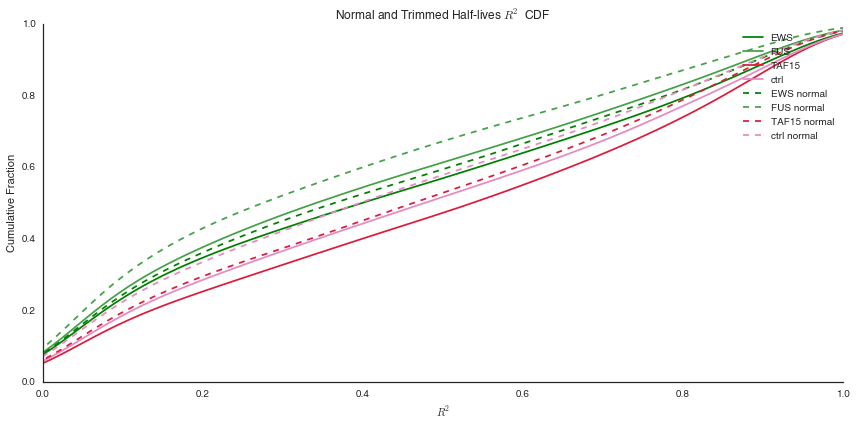

In [35]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(12,6)) as fig:
    ax = fig.add_subplot(1,1,1)
    for name, df in good_halflives.ix['trimmed_half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color_map[name], ax=ax)
    
    for name, df  in good_halflives.ix['half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name + " normal", linestyle="--", color=color_map[name], ax=ax)
    
    ax.set_xlim(0,1)
    sns.despine(ax=ax)
    ax.set_title("Normal and Trimmed Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    ax.legend()

#Method:
The equation I'm trying to fit is N(t) = $N_0e^{-\lambda t}$
If you take the ln of each side

ln(N(t)) = $ln(N_0) + -\lambda t$

You can fit this via linear regression, where slope = $-\lambda$

For scramble control I scrambled time points for the same gene.

#Conclusions
1. Scramble has somewhat uniform error, and is always worse than normal, which is good
2. If you trim off $T_0$ you get strictly better results from fitting the linear regression.  Could this be because you've just got fewer datapoints to fit?

#Final Dataset Choices
Because trimming is better I'm just going to use that dataset for the rest of the analysis
Really don't know if trimming is better, need to hit on it a bit more

All trimmed half-lives where we have high confidence values for control and the thing of interest

In [36]:
well_correlated_halflives = good_halflives[good_halflives.r2 > .6]
high_confidence_halflives = well_correlated_halflives.ix['trimmed_half_lives']
high_confidence_halflives = high_confidence_halflives.halflife.unstack()

#Descriptive Stats

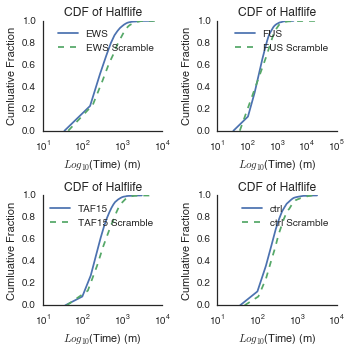

In [37]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(num_cols * 2.5, num_rows * 2.5)) as fig:
    for x, (name, df) in enumerate(well_correlated_halflives.groupby(level="knockdown")):
        ax = fig.add_subplot(2,2,x+1)
        
        dataviz.plot_cdf(df.ix['trimmed_half_lives'].halflife,
                         label=name, 
                         #color=colors[x], 
                         ax=ax)
        dataviz.plot_cdf(df.ix['trimmed_shuffled_half_lives'].halflife, 
                         label=name + " Scramble", 
                         linestyle="--", 
                         #color=color, 
                         ax=ax)

        ax.set_title("CDF of Halflife")
        ax.set_ylabel("Cumluative Fraction")
        ax.set_xlabel("$Log_{10}$(Time) (m)")
        ax.set_xscale("log", basex=10)
        ax.legend()
        sns.despine(ax=ax)

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


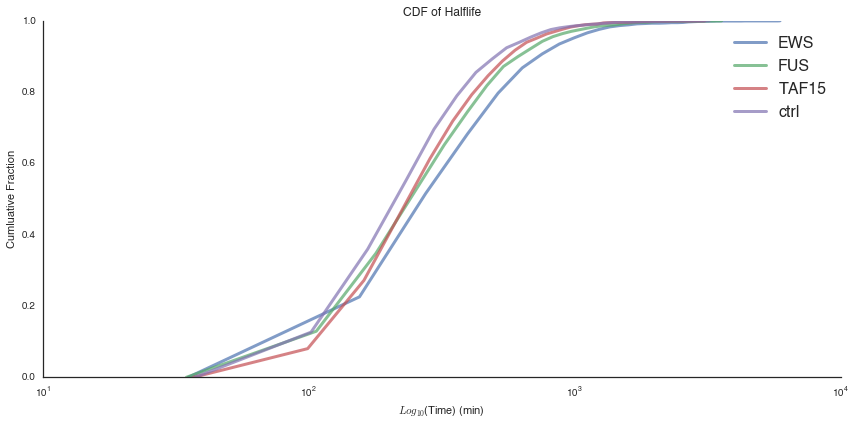

In [38]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(12,6)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    #add in scrambles
    #log time scale
    for name, df in high_confidence_halflives.groupby(level="knockdown"):
            dataviz.plot_cdf(df.irow(0).dropna(), label=name, ax=ax, alpha=.7, linewidth=3)
    ax.legend(loc=0, fontsize=16)
    #ax.set_xlim(0, 2000)
    ax.set_title("CDF of Halflife")
    ax.set_ylabel("Cumluative Fraction")
    ax.set_xlabel("$Log_{10}$(Time) (min)")
    ax.set_xscale("log", basex=10)
    sns.despine(ax=ax)

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


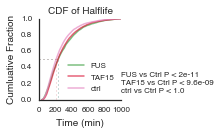

In [39]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "taf15_halflife_cdf.svg"), figsize=(2.0 * num_cols, 2.0 * num_rows)) as fig:
    grouped_halflives = high_confidence_halflives[high_confidence_halflives < 1000].groupby(level="knockdown")

    for x, (name, df) in enumerate(grouped_halflives):
        if not ((name == "TAF15") or (name == "FUS") or (name == "ctrl")):
            continue
        ax = fig.add_subplot(num_rows,num_cols, 1)
        kd = df.irow(0).dropna()
        ctrl = grouped_halflives.get_group("ctrl").irow(0).dropna()
        cdf = sm.distributions.ECDF(kd) 
        index = np.where((cdf.y > .499) & (cdf.y < .500001))[0][0]
        y_mid = cdf.y[index]
        x_mid = cdf.x[index]
        dataviz.plot_cdf(kd, 
                         label=name, 
                         ax=ax, 
                         alpha=.7,
                         color=color_map[name], 
                         linewidth=1.5)
        
        ax.plot([0, x_mid, x_mid], [y_mid, y_mid, 0], linewidth=.5, alpha=.7, linestyle=":")
        d, p_value = ks_2samp(kd, ctrl)
        ax.legend(loc=0, fontsize=8)
        ax.set_title("CDF of Halflife", fontsize=10)
        ax.set_ylabel("Cumluative Fraction", fontsize=10)
        ax.set_xlabel("Time (min)", fontsize=10)
        ax.set_xlim(0,1000)
        ax.set_ylim(0,1)
        ax.text(1, .4 - (x / 10.0), "{} vs Ctrl P < {:.2}".format(name, p_value), 
               transform=ax.transAxes, fontsize=8)
        
        [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
        sns.despine(ax=ax)

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


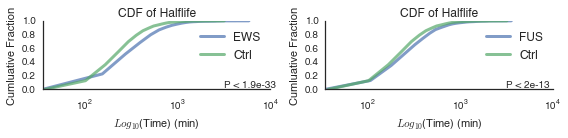

In [40]:
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "other_halflife_cdf.svg"), figsize=(4.0 * num_cols, 2.0 * num_rows)) as fig:
    grouped_halflives = high_confidence_halflives.groupby(level="knockdown")
    #add in scrambles
    #log time scale
    for x, (name, df) in enumerate(grouped_halflives):
        if name == "ctrl" or name == "TAF15":
            continue
        ax = fig.add_subplot(num_rows,num_cols, x+1)
        kd = df.irow(0).dropna()
        ctrl = grouped_halflives.get_group("ctrl").irow(0).dropna()
        dataviz.plot_cdf(kd, label=name, ax=ax, alpha=.7, linewidth=3)
        dataviz.plot_cdf(ctrl, label="Ctrl", ax=ax, alpha=.7, linewidth=3)
        d, p_value = ks_2samp(kd, ctrl)
        ax.legend(loc=0, fontsize=12)
        ax.set_title("CDF of Halflife")
        ax.set_ylabel("Cumluative Fraction")
        ax.set_xlabel("$Log_{10}$(Time) (min)")
        ax.set_xscale("log", basex=10)
        ax.set_xlim(0, pow(10,4))

        ax.text(pow(10,3.5), .05, "P < {:.2}".format(p_value))
        sns.despine(ax=ax)

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


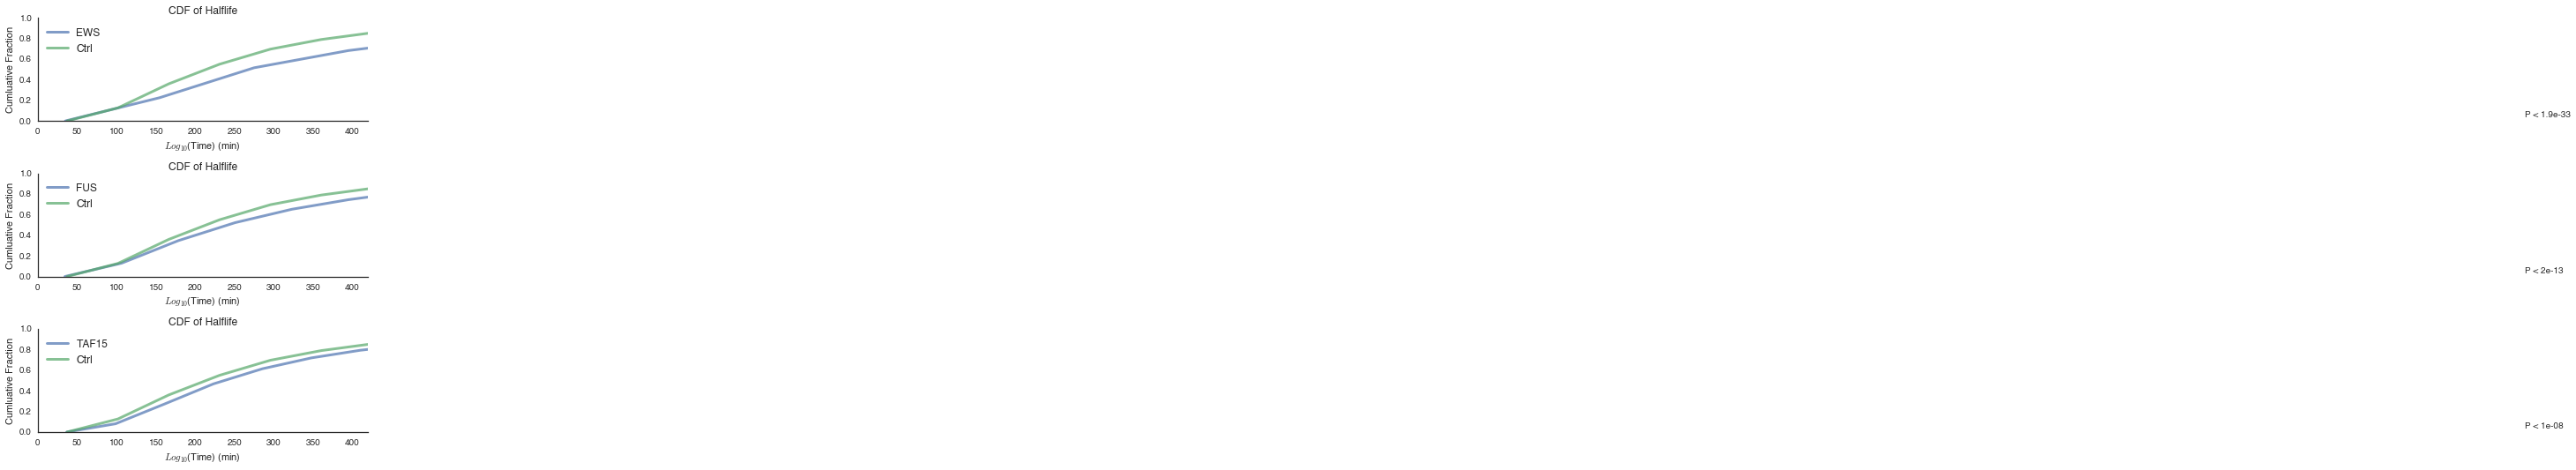

In [41]:
num_rows = 3
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6.0 * num_cols, 2.5 * num_rows)) as fig:
    grouped_halflives = high_confidence_halflives.groupby(level="knockdown")
    #add in scrambles
    #log time scale
    for x, (name, df) in enumerate(grouped_halflives):
        if name == "ctrl":
            continue
        ax = fig.add_subplot(num_rows,num_cols, x+1)
        kd = df.irow(0).dropna()
        ctrl = grouped_halflives.get_group("ctrl").irow(0).dropna()
        dataviz.plot_cdf(kd, label=name, ax=ax, alpha=.7, linewidth=3)
        dataviz.plot_cdf(ctrl, label="Ctrl", ax=ax, alpha=.7, linewidth=3)
        d, p_value = ks_2samp(kd, ctrl)
        ax.legend(loc=0, fontsize=12)
        ax.set_title("CDF of Halflife")
        ax.set_ylabel("Cumluative Fraction")
        ax.set_xlabel("$Log_{10}$(Time) (min)")
        #ax.set_xscale("log", basex=10)
        ax.set_xlim(0, 420)

        ax.text(pow(10,3.5), .05, "P < {:.2}".format(p_value))
        sns.despine(ax=ax)

Something is wrong with my calculations... I get much longer $\lambda$ than kasey

Figure Legend: Overall distributions of halflife for each RBP and the control.  Split out into three comparisons for easier visualization and comparison

#Conclusions
1. TAF15, FUS and EWS all appear to have somewhat of a stabalizing effect when knocked down.  

#Identify RNAs with large $\Delta$ half-life


In [42]:
delta_halflife_prep = high_confidence_halflives[high_confidence_halflives.ix['ctrl'].dropna().index]
delta_halflife = delta_halflife_prep - delta_halflife_prep.ix['ctrl']

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


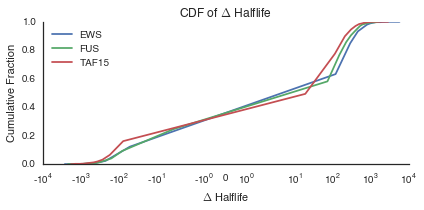

In [43]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)

    for name, df in delta_halflife.groupby(level="knockdown"):
        if name == "ctrl":
            continue
        dataviz.plot_cdf(df.irow(0).dropna(), label=name, ax=ax)
    ax.legend(loc=0)
    #ax.set_xlim(-500, 500)
    ax.set_title("CDF of $\Delta$ Halflife")
    ax.set_ylabel("Cumulative Fraction")
    ax.set_xlabel("$\Delta$ Halflife")
    ax.set_xscale("symlog", basex=10)
    sns.despine(ax=ax)

In [44]:
high_confidence_halflives

gene       ENSG00000000457.8  ENSG00000000460.12  ENSG00000001036.8  \
knockdown                                                             
EWS                      NaN                 NaN         922.603838   
FUS               211.308572          778.998015                NaN   
TAF15              80.968739                 NaN                NaN   
ctrl                     NaN                 NaN                NaN   

gene       ENSG00000001084.6  ENSG00000001167.10  ENSG00000001629.5  \
knockdown                                                             
EWS               492.531912          407.688416                NaN   
FUS               208.436150          227.186733        1524.395936   
TAF15                    NaN                 NaN                NaN   
ctrl                     NaN                 NaN         228.568338   

gene       ENSG00000002016.11  ENSG00000002587.5  ENSG00000002919.10  \
knockdown                                                              
EWS                       NaN                NaN                 NaN   
FUS                349.928648         110.871814                 NaN   
TAF15              139.814369                NaN          203.469173   
ctrl                      NaN                NaN           92.224724   

gene       ENSG00000003096.9        ...          ENSG00000271662.1  \
knockdown                           ...                              
EWS                      NaN        ...                        NaN   
FUS                      NaN        ...                        NaN   
TAF15             233.312464        ...                 388.529544   
ctrl                     NaN        ...                        NaN   

gene       ENSG00000271707.1  ENSGR0000167393.12  ENSGR0000169084.8  \
knockdown                                                             
EWS                      NaN                 NaN                NaN   
FUS                      NaN                 NaN                NaN   
TAF15                    NaN          331.611834                NaN   
ctrl              198.872531                 NaN         134.080589   

gene       ENSGR0000169093.10  ENSGR0000182484.10  ENSGR0000197976.6  \
knockdown                                                              
EWS                563.263994                 NaN         409.241647   
FUS                       NaN          204.939245         191.803648   
TAF15                     NaN                 NaN         294.001854   
ctrl                      NaN                 NaN                NaN   

gene       ENSGR0000214717.4  ENSGR0000223773.2  ENSGR0000237801.1  
knockdown                                                           
EWS                      NaN                NaN           80.72641  
FUS               402.127316                NaN                NaN  
TAF15             153.324804         235.148293                NaN  
ctrl                     NaN                NaN                NaN  

[4 rows x 7370 columns]

In [45]:
high_confidence_halflives[name_to_gene_id['NUP37']]

knockdown
EWS              NaN
FUS              NaN
TAF15     235.046628
ctrl     1714.916832
Name: ENSG00000075188.4, dtype: float64

In [46]:
delta_halflife_prep = high_confidence_halflives[high_confidence_halflives.ix['ctrl'].dropna().index]
delta_halflife = np.log2(delta_halflife_prep / delta_halflife_prep.ix['ctrl'])

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


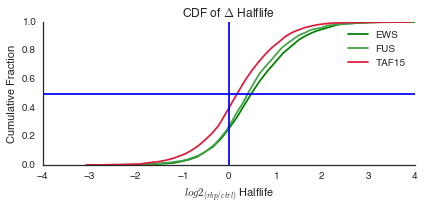

In [47]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)

    for name, df in delta_halflife.groupby(level="knockdown"):
        if name == "ctrl":
            continue
        dataviz.plot_cdf(df.irow(0).dropna(), label=name, color=color_map[name], ax=ax)
    ax.legend(loc=0)
    ax.set_xlim(-4, 4)
    ax.set_title("CDF of $\Delta$ Halflife")
    ax.set_ylabel("Cumulative Fraction")
    ax.set_xlabel("$log2_{(rbp/ctrl)}$ Halflife")
    ax.axhline(.5)
    ax.axvline(0)
    #ax.set_xscale("symlog", basex=10)
    sns.despine(ax=ax)

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


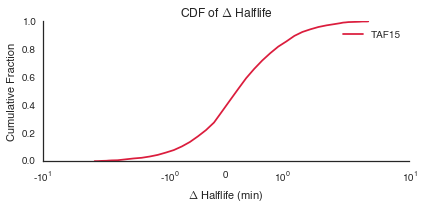

In [48]:
with dataviz.Figure(os.path.join(img_dir, "taf15_delta_halflife.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)

    for name, df in delta_halflife.groupby(level="knockdown"):
        if name != "TAF15":
            continue
        dataviz.plot_cdf(df.irow(0).dropna(), label=name, color=color_map[name], ax=ax)
    ax.legend(loc=0)
    #ax.set_xlim(-500, 500)
    ax.set_title("CDF of $\Delta$ Halflife")
    ax.set_ylabel("Cumulative Fraction")
    ax.set_xlabel("$\Delta$ Halflife (min)")
    ax.set_xscale("symlog", basex=10)
    sns.despine(ax=ax)

#Plot comparisons of delta halflife between taf15 and FUS

In [49]:
fus = delta_halflife.ix[['TAF15', 'FUS']].dropna(axis=1).ix['FUS']
taf15 = delta_halflife.ix[['TAF15', 'FUS']].dropna(axis=1).ix['TAF15']

In [50]:
foo = np.log10(high_confidence_halflives.ix[['TAF15', 'FUS', 'ctrl']].dropna(axis=1))

LinregressResult(slope=0.70129576587139697, intercept=0.7557320923741746, rvalue=0.68067435557109146, pvalue=1.8871932770830352e-147, stderr=0.023020581050097345)


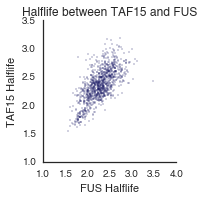

In [51]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "destabalization_correlation.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(foo.ix['TAF15'], foo.ix['FUS'], s=.5, alpha=.7)
    print linregress(foo.ix['TAF15'], foo.ix['FUS'])
    sns.despine(ax=ax)
    ax.set_title("Halflife between TAF15 and FUS")
    ax.set_ylabel("TAF15 Halflife")
    ax.set_xlabel("FUS Halflife")

LinregressResult(slope=0.60408039463095675, intercept=0.83519110039814248, rvalue=0.62912494361355986, pvalue=9.3782004187679664e-120, stderr=0.02276379226175421)


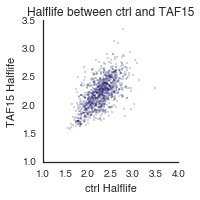

In [52]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "destabalization_correlation.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(foo.ix['TAF15'], foo.ix['ctrl'], s=.5, alpha=.7)
    print linregress(foo.ix['TAF15'], foo.ix['ctrl'])
    sns.despine(ax=ax)
    ax.set_title("Halflife between ctrl and TAF15")
    ax.set_ylabel("TAF15 Halflife")
    ax.set_xlabel("ctrl Halflife")

LinregressResult(slope=0.70478090675343563, intercept=0.79706153739589136, rvalue=0.65682570191570799, pvalue=5.8698573963155953e-134, stderr=0.024677181078001331)


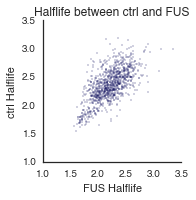

In [53]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "destabalization_correlation.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(foo.ix['ctrl'], foo.ix['FUS'], s=.5, alpha=.7)
    print linregress(foo.ix['ctrl'], foo.ix['FUS'])
    sns.despine(ax=ax)
    ax.set_title("Halflife between ctrl and FUS")
    ax.set_ylabel("ctrl Halflife")
    ax.set_xlabel("FUS Halflife")

LinregressResult(slope=0.5401293567191906, intercept=-0.023848788017349271, rvalue=0.52869560712641028, pvalue=1.3614210394838752e-78, stderr=0.026448381518559189)


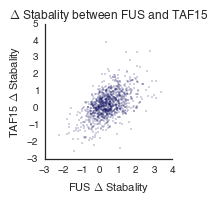

In [54]:
num_rows = 5
num_cols = 5
with dataviz.Figure(os.path.join(img_dir, "destabalization_correlation.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(fus, taf15, s=.5, alpha=.7)
    print linregress(fus, taf15)
    sns.despine(ax=ax)
    ax.set_title("$\Delta$ Stabality between FUS and TAF15")
    ax.set_ylabel("TAF15 $\Delta$ Stabality")
    ax.set_xlabel("FUS $\Delta$ Stabality")

In [55]:
taf15_delta_genes = delta_halflife.ix['TAF15'].dropna()
taf15_delta_genes.sort()

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from IPython.kernel.zmq import kernelapp as app


In [56]:
taf15_stabalized_df = pd.concat({"Stabalized": taf15_delta_genes[taf15_delta_genes > 0],
                                 "Destabalized": taf15_delta_genes[taf15_delta_genes < 0]}, names=['type'])

In [57]:
taf15_stabalized_df.groupby(level="type").count()

type
Destabalized     751
Stabalized      1133
dtype: int64

#Add to the plot if the genes are bound in mouse

In [58]:
from clipper.src import CLIP_analysis

In [59]:
regions, all_regions = CLIP_analysis.regions_generator()

In [60]:
genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")

rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
        "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
        "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
 }

binding_df = []
assigned_peaks = {}
for name, rbp in rbps.items():
    overlapping_genes = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

    cluster_regions = CLIP_analysis.assign_to_regions(overlapping_genes, name, 
                                    regions, "assigned", nrand=0, species="mm9")
    assigned_peaks[name] = cluster_regions
    for region in cluster_regions.keys():
        gene_names = pd.Series(Counter([interval.name.split(",")[0] for interval in cluster_regions[region]['real']]),
                                name=name + "_" + region)
        gene_names.name = (name, region)
        binding_df.append(gene_names)
binding_df = pd.concat(binding_df,axis=1)
binding_df.columns = pd.MultiIndex.from_tuples(binding_df.columns)
binding_df = binding_df.T
binding_df = binding_df.stack()
binding_df.index.names = ['rbp', 'region', 'gene_id']
binding_df = binding_df.sort_index()

There are a total 69657 clusters I'll examine
For region: cds found 521 that overlap and 69136 that don't
For region: three_prime_utrs found 2999 that overlap and 66137 that don't
For region: five_prime_utrs found 194 that overlap and 65943 that don't
For region: proxintron500 found 8425 that overlap and 57518 that don't
For region: distintron500 found 57457 that overlap and 61 that don't
After assigning 61 un-categorized regions
There are a total 155599 clusters I'll examine
For region: cds found 13193 that overlap and 142406 that don't
For region: three_prime_utrs found 10705 that overlap and 131701 that don't
For region: five_prime_utrs found 944 that overlap and 130757 that don't
For region: proxintron500 found 21211 that overlap and 109546 that don't
For region: distintron500 found 109329 that overlap and 217 that don't
After assigning 217 un-categorized regions
There are a total 44610 clusters I'll examine
For region: cds found 1470 that overlap and 43140 that don't
For region: t

In [61]:
mouse_gene_id_names = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/mouse_gene_id_to_names.txt", index_col=0)
human_mouse_genes = pd.read_table("/nas3/gpratt/projects/taf15/mouse_human_genes.txt", index_col=2)
mouse_human_genes = human_mouse_genes
mouse_human_genes['gene_id'] = mouse_human_genes.index
mouse_human_genes.index = mouse_human_genes['Ensembl Gene ID']
mouse_human_genes_dict = dict(izip(mouse_human_genes.index, mouse_human_genes.gene_id))

In [62]:
new_index = []
for rbp, region, gene_id in binding_df.index:
    try:
        gene_id  = mouse_human_genes_dict[gene_id.split(".")[0]]
    except KeyError:
        gene_id = "error"
    new_index.append([rbp, region, gene_id])
binding_df.index = pd.MultiIndex.from_tuples(new_index)

#Plot Stabality Experiments

In [63]:
grouped_kd_rpkms = stabality_rpkm.groupby(level="knockdown")

In [64]:
def format_df(df):
    """ formats df for plotting in heatmap very specific helper function"""
    df.index = df.index.get_level_values(level=0)
    df.columns = [gene_id_to_name[gene_id] for gene_id in df.columns]
    return df

def get_halflives(df, rbp):
    halflives = trimmed_half_lives.swaplevel(0,1).ix[df.columns].xs(rbp, level=1)
    halflives.halflife[(halflives.r2 < .6) | (halflives.halflife < 0)] = np.nan
    halflives.index = [gene_id_to_name[gene_id] for gene_id in halflives.index]
    return halflives.halflife

In [67]:
halflife_table = high_confidence_halflives.T.drop("EWS", axis=1)
halflife_table['gene_name'] = halflife_table.index.map(lambda x: gene_id_to_name[x])
halflife_table.index.name = "gencode_id"
halflife_table.columns = ['FUS Halflife', 'TAF15 Halflife', 'Control Halflife', 'Gene Name']
halflife_table = halflife_table.fillna("N/A")
halflife_table.to_csv("/nas3/gpratt/Dropbox/TAF15_Manuscript/Tables/Table_S4.csv")

In [68]:
rip_targets = """CGGBP1
TCERG1
PRKRIR
SENP2
RAPGEF1
ATXN7L3B
NUFIP1
URB1
CLN8""".split("\n")
rip_gene_targets = [name_to_gene_id[gene_name] for gene_name in rip_targets]

In [69]:
number_changing = 5
destabalized_gene_list = taf15_stabalized_df.ix['Destabalized'][:number_changing].index | taf15_stabalized_df.ix['Destabalized'][rip_gene_targets].dropna().index 

taf15_destabalized = grouped_kd_rpkms.get_group("TAF15")[destabalized_gene_list]
fus_destabalized = grouped_kd_rpkms.get_group("FUS")[destabalized_gene_list]
ctrl_destabalized = grouped_kd_rpkms.get_group("ctrl")[destabalized_gene_list]

taf15_destabalized_bound_in_mouse_brain = binding_df.ix['taf15', 'all'][[gene_id.split(".")[0] for gene_id in taf15_destabalized]]
fus_destabalized_bound_in_mouse_brain = binding_df.ix['fus', 'all'][[gene_id.split(".")[0] for gene_id in fus_destabalized]]

taf15_destabalized_hl = get_halflives(taf15_destabalized, "TAF15")
fus_destabalized_hl = get_halflives(fus_destabalized, "FUS")
ctrl_destabalized_hl = get_halflives(ctrl_destabalized, "ctrl")

taf15_destabalized = format_df(taf15_destabalized)
fus_destabalized = format_df(fus_destabalized)
ctrl_destabalized = format_df(ctrl_destabalized)

number_changing = 10
number_changing = number_changing * -1
stabalized_gene_list = taf15_stabalized_df.ix['Stabalized'][number_changing:].index | taf15_stabalized_df.ix['Stabalized'][rip_gene_targets].dropna().index

taf15_stabalized = grouped_kd_rpkms.get_group("TAF15")[stabalized_gene_list]
fus_stabalized = grouped_kd_rpkms.get_group("FUS")[stabalized_gene_list]
ctrl_stabalized = grouped_kd_rpkms.get_group("ctrl")[stabalized_gene_list]

taf15_stabalized_bound_in_mouse_brain = binding_df.ix['taf15', 'all'][[gene_id.split(".")[0] for gene_id in taf15_stabalized]]
fus_stabalized_bound_in_mouse_brain = binding_df.ix['fus', 'all'][[gene_id.split(".")[0] for gene_id in fus_stabalized]]

taf15_stabalized_hl = get_halflives(taf15_stabalized, "TAF15")
fus_stabalized_hl = get_halflives(fus_stabalized, "FUS")
ctrl_stabalized_hl = get_halflives(ctrl_stabalized, "ctrl")

taf15_stabalized = format_df(taf15_stabalized)
fus_stabalized = format_df(fus_stabalized)
ctrl_stabalized = format_df(ctrl_stabalized)

In [70]:
pd.concat({"stabalized": pd.concat({"taf15": taf15_stabalized_hl,
           "fus": fus_stabalized_hl,
           "ctrl": ctrl_stabalized_hl}), 

"destabalized": pd.concat({"taf15": taf15_destabalized_hl,
           "fus": fus_destabalized_hl,
           "ctrl": ctrl_destabalized_hl})}).unstack()

AC027612.4    ATXN7L3B       C9orf3         CDK7  \
destabalized ctrl   2037.258249  699.239358          NaN          NaN   
             fus            NaN         NaN          NaN          NaN   
             taf15   242.746159  210.616940          NaN          NaN   
stabalized   ctrl           NaN         NaN   121.596294   106.234964   
             fus            NaN         NaN          NaN   288.671942   
             taf15          NaN         NaN  1048.248895  1060.333868   

                         CGGBP1        CLN8       EBAG9        GPN2  \
destabalized ctrl   1345.106795         NaN         NaN         NaN   
             fus            NaN         NaN         NaN         NaN   
             taf15   510.822014         NaN         NaN         NaN   
stabalized   ctrl           NaN   86.523885   65.012017   85.737654   
             fus            NaN  274.707461         NaN  585.857983   
             taf15          NaN  634.495883  382.740960  910.908565   

                          MOCS1      NUFIP1     ...         RAPGEF1  \
destabalized ctrl           NaN  470.540783     ...      741.151543   
             fus            NaN  182.437740     ...             NaN   
             taf15          NaN   81.569600     ...      187.413879   
stabalized   ctrl    202.761819         NaN     ...             NaN   
             fus     264.060424         NaN     ...             NaN   
             taf15  3085.538679         NaN     ...             NaN   

                          RPRD2       SENP2      SEPHS2      SMURF2  \
destabalized ctrl   1770.013025  988.626820         NaN         NaN   
             fus            NaN         NaN         NaN         NaN   
             taf15   274.303359  289.397852         NaN         NaN   
stabalized   ctrl           NaN         NaN   65.196268  134.436222   
             fus            NaN         NaN  270.470449  569.436593   
             taf15          NaN         NaN  658.601614  754.454685   

                          SNX9       TCERG1      TEX264        URB1  \
destabalized ctrl          NaN  1248.537959         NaN         NaN   
             fus           NaN   398.578900         NaN         NaN   
             taf15         NaN   454.684978         NaN         NaN   
stabalized   ctrl   103.152060          NaN   76.580816  341.869221   
             fus           NaN          NaN         NaN  422.381577   
             taf15  864.466138          NaN  484.876177  804.336572   

                        ZNF439  
destabalized ctrl   572.765709  
             fus           NaN  
             taf15   88.652022  
stabalized   ctrl          NaN  
             fus           NaN  
             taf15         NaN  

[6 rows x 22 columns]

In [71]:
def plot_heatmap(df, halflives, ax, cbar=False, cbar_ax=None):
    internally_normalized = df.T
    internally_normalized = internally_normalized.div(internally_normalized[0], axis=0)

    sns.heatmap(np.log2(internally_normalized), 
                linewidths=.1, 
                vmax=vmax,
                vmin=vmin,
                cmap=cmap,
                cbar=cbar,
                cbar_ax=cbar_ax,
                linecolor='k',
                ax=ax)
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    
    ypos = ax.get_yticks()
    xpos = ax.get_xticks()
    halflife_xpos = (xpos[-1] - xpos[-2]) + xpos[-1] 

    
    for y, halflife in zip(ypos, halflives):
        if np.isnan(halflife):
            halflife = "NA"
            ax.text(halflife_xpos, y, "N/A", ha="left", va="center", fontsize=8)
        else:
            ax.text(halflife_xpos, y, "{:,.1f}".format(halflife),
                    ha="left", va="center", fontsize=8)
        
    halflife_ypos = ypos[-1] + (ypos[-1] - ypos[-2])
    ax.text(halflife_xpos, halflife_ypos, "$T_{1/2}$ (min)", ha="left", va="center", fontsize=8)
        
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(7) for tick in ax.get_xticklabels()]
    
def plot_bound(df, ax=ax):
    df = df.fillna(0)
    df[df >= 1] = 1
    sns.heatmap(pd.DataFrame(df), 
                cbar=False, 
                xticklabels=False, 
                yticklabels=False,
               linecolor='k')

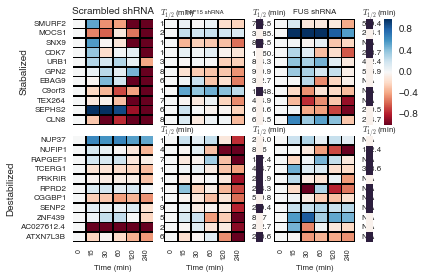

In [72]:
num_rows = 2
num_cols = 18
gs = gridspec.GridSpec(num_rows, num_cols)
vmin = -1.0
vmax = 1.0
cmap = "RdBu"
with dataviz.Figure(os.path.join(img_dir, "stabality_heatmap.svg"), figsize=(6,4)) as fig:
    ax = fig.add_subplot(gs[0,0:5])
    
    plot_heatmap(ctrl_stabalized, reversed(ctrl_stabalized_hl), ax=ax)
    ax.set_title("Scrambled shRNA", fontsize=10)
    ax.set_ylabel("Stabalized", fontsize=10)
    ax.set_xlabel("")
    ax.set_xticklabels([])

    ax = fig.add_subplot(gs[0,5:10])
    plot_heatmap(taf15_stabalized, reversed(taf15_stabalized_hl), ax=ax)
    ax.set_yticklabels([])
    ax.set_title("TAF15 shRNA", fontsize=6)
    ax.set_xlabel("")
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(gs[0,10])
    plot_bound(taf15_stabalized_bound_in_mouse_brain, ax)
    #ax.set_title("Bound", fontsize=6)
    
    ax = fig.add_subplot(gs[0,11:16])
    cbar_ax = fig.add_subplot(gs[0,17])

    plot_heatmap(fus_stabalized, reversed(fus_stabalized_hl), ax=ax, cbar=True, cbar_ax=cbar_ax)
    ax.set_yticklabels([])
    ax.set_title("FUS shRNA", fontsize=8)
    ax.set_xlabel("")
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(gs[0,16])
    plot_bound(fus_stabalized_bound_in_mouse_brain, ax)
    #ax.set_title("Bound", fontsize=8)

    ax = fig.add_subplot(gs[1,0:5])
    plot_heatmap(ctrl_destabalized, reversed(ctrl_destabalized_hl), ax=ax)
    ax.set_ylabel("Destabilized", fontsize=10)
    ax.set_xlabel("Time (min)", fontsize=8)

    ax = fig.add_subplot(gs[1,5:10])
    plot_heatmap(taf15_destabalized,reversed(taf15_destabalized_hl), ax=ax)
    ax.set_yticklabels([])
    ax.set_xlabel("Time (min)", fontsize=8)

    ax = fig.add_subplot(gs[1,10])
    plot_bound(taf15_destabalized_bound_in_mouse_brain, ax)
    
    ax = fig.add_subplot(gs[1,11:16])
    plot_heatmap(fus_destabalized, reversed(fus_destabalized_hl), ax=ax)
    ax.set_yticklabels([])
    ax.set_xlabel("Time (min)", fontsize=8)
    
    ax = fig.add_subplot(gs[1,16])
    plot_bound(fus_destabalized_bound_in_mouse_brain, ax)

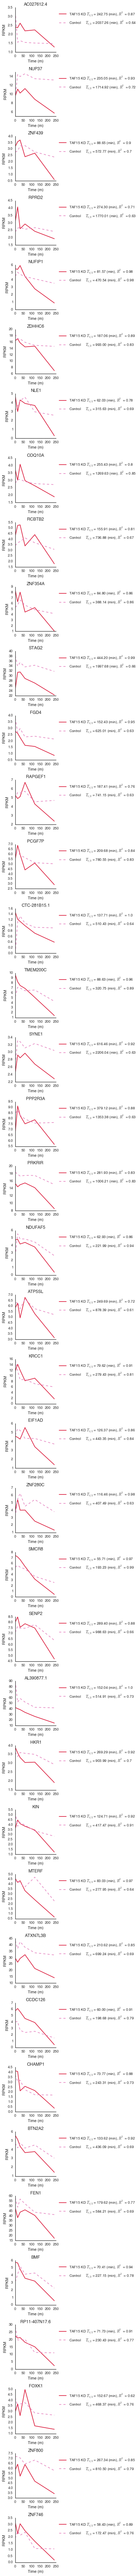

In [73]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 1) + 1 
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "top_40_destabalized_genes.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Destabalized'][:num_genes].index):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['TAF15']
        )
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])
        
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))

Figure Legend: Top 40 most destabalized TAF15 Genes

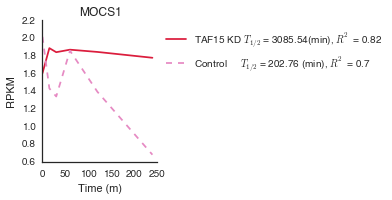

In [74]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 1
num_rows = (num_genes / 1) + 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "best_stabalized_gene.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Stabalized'][-1 * num_genes:].index):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
               color=color_map['TAF15'])
        
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])  
        
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))

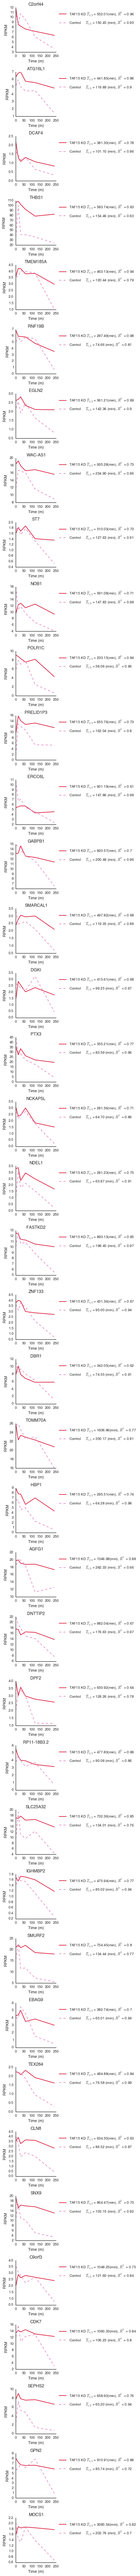

In [75]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 1) + 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "top_40_stabalized_genes.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Stabalized'][-1 * num_genes:].index):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
               color=color_map['TAF15'])
        
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])  
        
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))

Figure Legend: Top 40 Most stabalized TAF15 Genes

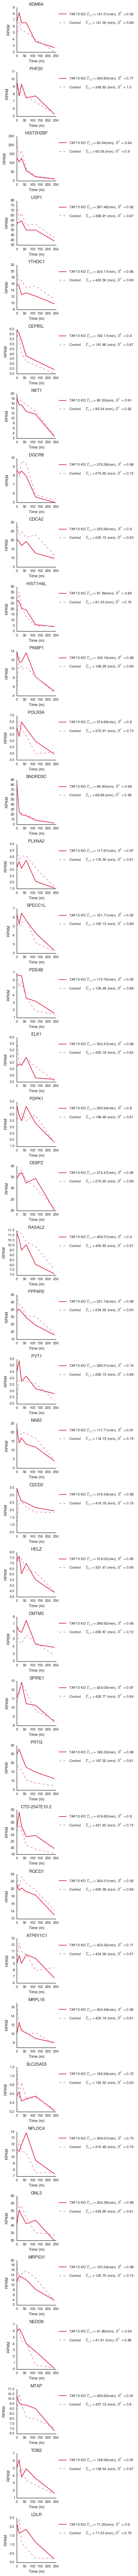

In [76]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 1) + 1
num_cols = 1
count = 0
with dataviz.Figure(os.path.join(img_dir, "no_change_group.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Stabalized'][:num_genes / 2].index):
        count += 1

        ax = fig.add_subplot(num_rows,num_cols, count)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['TAF15'])
        
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])
        
        ax.set_title(gene_id_to_name[gene])
        
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))
        
    for x, gene in enumerate(taf15_stabalized_df.ix['Destabalized'][-1 * (num_genes / 2):].index):
        count += 1

        ax = fig.add_subplot(num_rows,num_cols, count)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
               color=color_map['TAF15'])
        
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])     
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))

Figure Legend: Top 40 least changing genes, first 20 are the least $\Delta$ increase in stabality. Second 20 are the least $\Delta$ decrease in stabality

#Plot Genes that we are just going to show in the paper

In [77]:
def plot_individual_gene(gene_name, ax):
        gene = name_to_gene_id[gene_name]

        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        fus = grouped_kd_rpkms.get_group("FUS")[gene]

        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['TAF15'])

        halflife = trimmed_half_lives.ix['FUS', gene].halflife
        r2 = trimmed_half_lives.ix['FUS', gene].r2
        ax.plot(fus.index.get_level_values(level="time"), 
                fus.values, 
                label="FUS KD $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['FUS'])

        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])

        ax.set_title(gene_id_to_name[gene], fontsize=12)

        ax.set_xlabel("Time (m)", fontsize=8)
        ax.set_ylabel("RPKM", fontsize=8)
        sns.despine(ax=ax)
        [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
        ax.legend(loc=2, fontsize=8, bbox_to_anchor=(1.0, 1))

In [78]:
from matplotlib import pyplot as plt

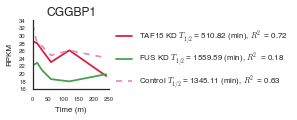

In [79]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 1
num_rows = 1
num_cols = 1

with dataviz.Figure(os.path.join(img_dir, "CGGBP1.svg"), figsize=(num_cols * 1.8,num_rows * 1.8)) as fig:
    ax = fig.add_subplot(num_rows,num_cols, 1)
    plot_individual_gene('CGGBP1', ax)

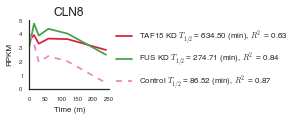

In [80]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "CLN8.svg"), figsize=(num_cols * 1.8,num_rows * 1.8)) as fig:
        ax = fig.add_subplot(num_rows,num_cols, 1)
        plot_individual_gene('CLN8', ax)

#Do GO Analysis, look for ALS related genes that have $\Delta$ stabality

In [81]:
hg19go = GO.hg19GO()

In [82]:
taf15_stabalized_df.groupby(level="type").count()

type
Destabalized     751
Stabalized      1133
dtype: int64

In [83]:
result = {}
for name, df in taf15_stabalized_df.groupby(level="type"):
    background = gencode_to_ensembl(stabality_rpkm.ix[0, 'ctrl'][stabality_rpkm.ix[0, 'ctrl'] > 2].index)
    result[name] = hg19go.enrichment(gencode_to_ensembl(df.index.get_level_values(level="gene")),
                                    background=background)

go_results = pd.concat(result, names=['stabality', 'go_term_id'])
go_results = go_results[go_results['Bonferroni-corrected Hypergeometric p-Value'] < .05]

/nas3/gpratt/anaconda/lib/python2.7/site-packages/gscripts-0.1.6-py2.7.egg/gscripts/GO/GO.py:88: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('Bonferroni-corrected Hypergeometric p-Value')


In [84]:
HTML(go_results.to_html())

In [85]:
#TAF15 Might change histone RNA stabality? Is that interesting?

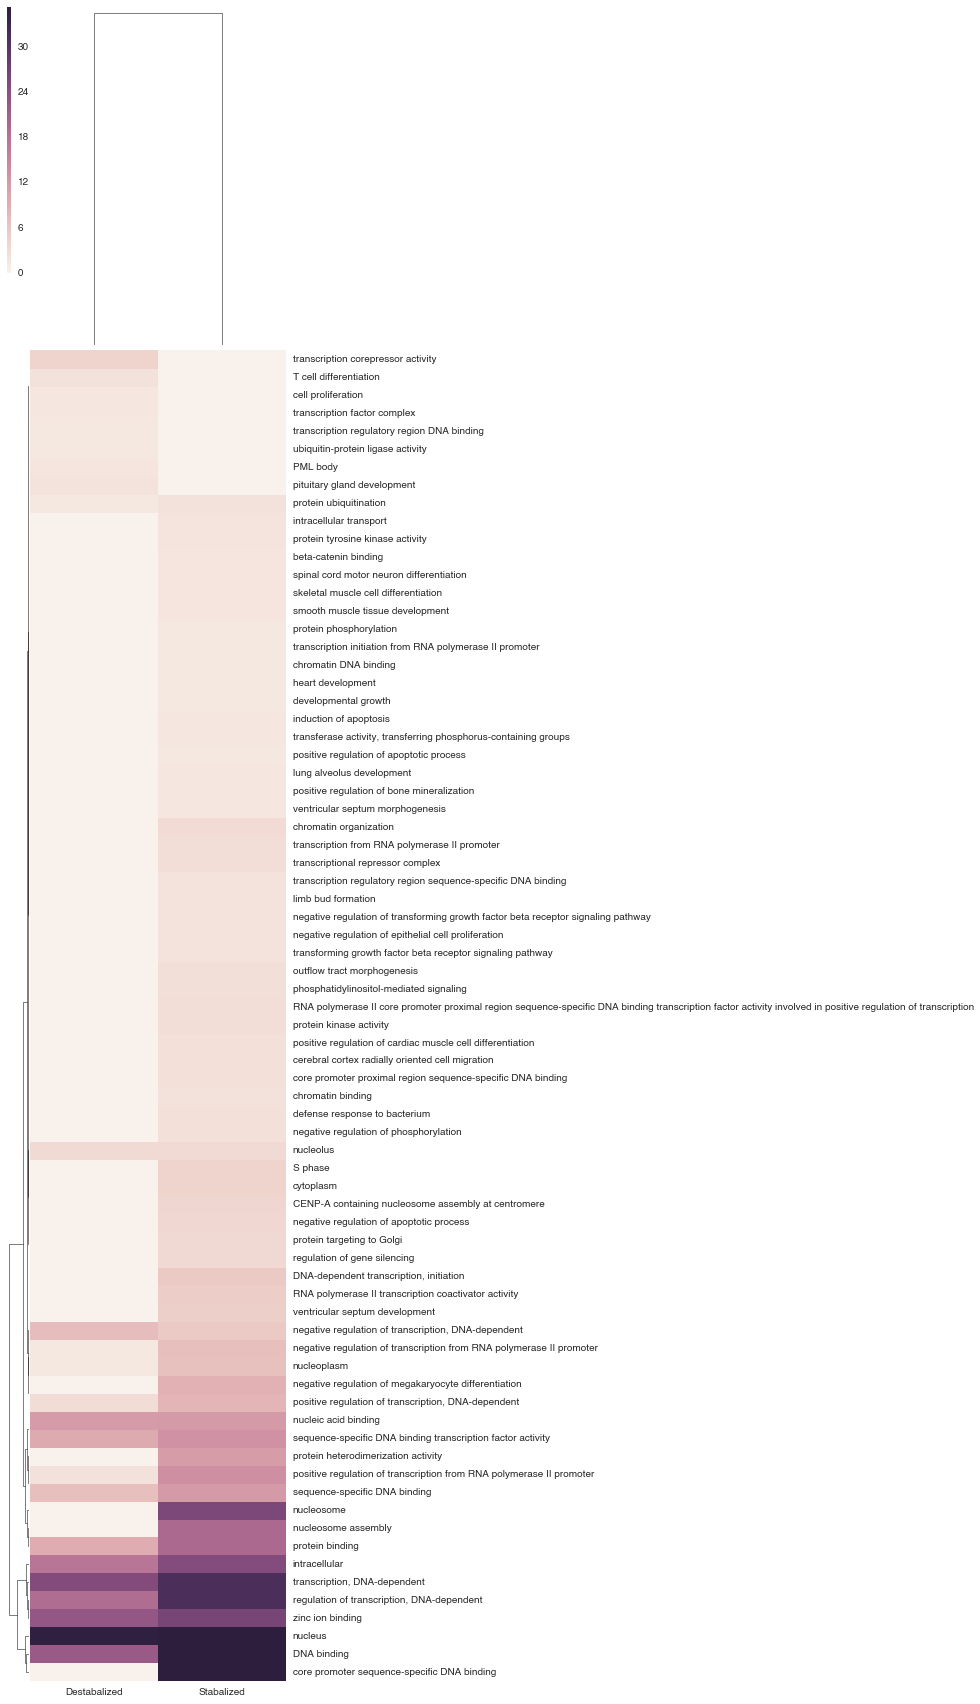

In [86]:
dataviz.plot_go_enrichment(go_results, figsize=(5,30))

#Validate RPKMs from Kasey's results

In [87]:
kasey_results = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/Half_life_analysis_khutt.xls", "Data", index_col=0)

Could look to see if the motif we define is enriched in stabalized vs destablized or unchanging elements...

#Looking at LIF

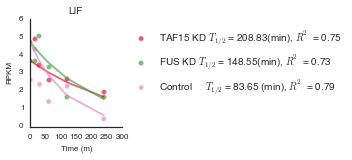

In [88]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 1
num_rows = (num_genes / 1) + 1
num_cols = 1
count = 0
with dataviz.Figure(os.path.join(img_dir, "lif_stabality.svg"), figsize=(num_cols * 2.0,num_rows * 2.0)) as fig:
    for x, gene in enumerate([name_to_gene_id['LIF']]):
        count += 1

        ax = fig.add_subplot(num_rows,num_cols, count)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.scatter(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['TAF15'],
                  alpha=.7)
        
        ax.plot(kd.index.get_level_values(level="time"), 
                decay_rate(kd.values[0], kd.index.get_level_values(level="time"), trimmed_half_lives.ix['TAF15', gene].decay),
                color=color_map['TAF15'],
               alpha=.7)        
        
        kd = grouped_kd_rpkms.get_group("FUS")[gene]
        halflife = trimmed_half_lives.ix['FUS', gene].halflife
        r2 = trimmed_half_lives.ix['FUS', gene].r2
        ax.scatter(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="FUS KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['FUS'],
                  alpha=.7)
        
        ax.plot(kd.index.get_level_values(level="time"), 
                decay_rate(kd.values[0], kd.index.get_level_values(level="time"), trimmed_half_lives.ix['FUS', gene].decay),
                color=color_map['FUS'],
               alpha=.7)   
            
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.scatter(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'],
                  alpha=.7)
        
        ax.plot(kd.index.get_level_values(level="time"), 
                decay_rate(kd.values[0], kd.index.get_level_values(level="time"), trimmed_half_lives.ix['ctrl', gene].decay),
                color=color_map['ctrl'], alpha=.7) 
        ax.set_title(gene_id_to_name[gene], fontsize=10)
        
        ax.set_xlabel("Time (m)", fontsize=8)
        ax.set_ylabel("RPKM", fontsize=8)
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))
        [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
        ax.set_xlim(0,)

#Number of stabalized and destabalized Genes

In [138]:
log2_fold_change_threshold = 1
taf15_delta = delta_halflife.ix['TAF15']
taf15_destabalized = taf15_delta[taf15_delta < (-1 * log2_fold_change_threshold)]
taf15_unchanging = taf15_delta[(taf15_delta > (-1 * log2_fold_change_threshold)) & (taf15_delta < log2_fold_change_threshold)]
taf15_stabalized = taf15_delta[taf15_delta > log2_fold_change_threshold]

fus_delta = delta_halflife.ix['FUS']
fus_destabalized = fus_delta[fus_delta < (-1 * log2_fold_change_threshold)]
fus_unchanging = fus_delta[(fus_delta > (-1 * log2_fold_change_threshold)) & (fus_delta < log2_fold_change_threshold)]
fus_stabalized = fus_delta[fus_delta > log2_fold_change_threshold]

In [143]:
fus_delta = delta_halflife.ix['FUS']
taf15_delta = delta_halflife.ix['TAF15']
all_regulated = pd.concat({
("taf15", "destabalized"): taf15_delta[taf15_delta < (-1 * log2_fold_change_threshold)],
("taf15", "unchanging"): taf15_delta[(taf15_delta > (-1 * log2_fold_change_threshold)) & (taf15_delta < log2_fold_change_threshold)],
("taf15", "stabalized"): taf15_delta[taf15_delta > log2_fold_change_threshold],
("fus", "destabalized"): fus_delta[fus_delta < (-1 * log2_fold_change_threshold)],
("fus", "unchanging"): fus_delta[(fus_delta > (-1 * log2_fold_change_threshold)) & (fus_delta < log2_fold_change_threshold)],
("fus", "stabalized"): fus_delta[fus_delta > log2_fold_change_threshold],
 }, names=['rbp', 'direction'])

In [145]:
all_regulated = pd.DataFrame(all_regulated)
all_regulated['gene_name'] = all_regulated.index.get_level_values(level="gene").map(lambda x:gene_id_to_name[x])
all_regulated.columns = ["delta_halflife", "gene_name"]

In [146]:
for name, df in all_regulated.groupby(level=['rbp', 'direction']):
    df.to_csv("/nas3/gpratt/Dropbox/TAF15_Manuscript/Tables/{}.csv".format("_".join(name)))

In [147]:
all_regulated.groupby(level=['rbp', 'direction']).count()

delta_halflife  gene_name
rbp   direction                              
fus   destabalized              44         44
      stabalized               330        330
      unchanging              1042       1042
taf15 destabalized             132        132
      stabalized               299        299
      unchanging              1453       1453

In [94]:
delta_halflife.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/delta_halflife.csv")

In [95]:
print len(taf15_destabalized), len(taf15_unchanging), len(taf15_stabalized)

132 1453 299


In [96]:
counts = {"taf15":  {"destabalized": len(taf15_destabalized), "unchanging": len(taf15_unchanging), "stabalized": len(taf15_stabalized)},
 "fus": {"destabalized": len(fus_destabalized), "unchanging": len(fus_unchanging), "stabalized": len(fus_stabalized)},
 "fus_and_taf15": {"destabalized":  len(taf15_destabalized.index & fus_destabalized.index), "unchanging": len(taf15_unchanging.index & fus_unchanging.index), "stabalized": len(taf15_stabalized.index & fus_stabalized.index)}}

counts = pd.DataFrame(counts)

In [98]:
groupings = {("taf15", "destabalized"): taf15_destabalized,
          ("taf15","unchanging"): taf15_unchanging,
          ("taf15",   "stabalized"): taf15_stabalized,
          ("fus", "destabalized"): fus_destabalized, 
          ( "fus",  "unchanging"): fus_unchanging, 
          ("fus",  "stabalized"): fus_stabalized,
          ("fus_and_taf15", "destabalized"):  taf15_destabalized[taf15_destabalized.index & fus_destabalized.index], 
          ("fus_and_taf15",   "unchanging"): taf15_unchanging[taf15_unchanging.index & fus_unchanging.index],
          ( "fus_and_taf15", "stabalized"): taf15_stabalized[taf15_stabalized.index & fus_stabalized.index]}


In [99]:
result = {}
for grouping in groupings:
    print grouping
    df = pd.DataFrame(groupings[grouping])
    df['gene_name'] = [gene_id_to_name[gene_id] for gene_id in df.index]
    result[grouping] = df

('fus_and_taf15', 'stabalized')
('fus', 'unchanging')
('fus', 'stabalized')
('taf15', 'stabalized')
('taf15', 'destabalized')
('fus', 'destabalized')
('taf15', 'unchanging')
('fus_and_taf15', 'unchanging')
('fus_and_taf15', 'destabalized')


In [148]:
pd.concat(result).to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stability/changing_genes.csv")

In [149]:
taf15_strict_unchanging = taf15_unchanging[(taf15_unchanging < .5) & (taf15_unchanging > -.5)]

In [150]:
fus_strict_unchanging = fus_unchanging[(fus_unchanging < .5) & (fus_unchanging > -.5)]

In [151]:
unchanging_genes = taf15_strict_unchanging.index & fus_strict_unchanging.index


In [152]:
overlapping_unchanging_genes = trimmed_half_lives.swaplevel(0,1).ix[unchanging_genes].halflife.unstack()

In [153]:
overlapping_unchanging_genes['gene_name'] = [gene_id_to_name[gene_id] for gene_id in overlapping_unchanging_genes.index]

In [154]:
overlapping_unchanging_genes.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/unchanging_genes.csv")

#Run go analysis on this set of genes

In [155]:
background = list(gencode_to_ensembl(stabality_rpkm.ix[0, 'ctrl'][stabality_rpkm.ix[0, 'ctrl'] > 2].index))

In [156]:
changing_go_analysis = {("taf15", "destabalized"): hg19go.enrichment(gencode_to_ensembl(taf15_destabalized.index), 
                                                       background=background),
                        ("taf15","unchanging"): hg19go.enrichment(gencode_to_ensembl(taf15_unchanging.index), 
                                                     background=background),
                        ("taf15", "stabalized"): hg19go.enrichment(gencode_to_ensembl(taf15_stabalized.index),
                                                     background=background),
                        ("fus", "destabalized"): hg19go.enrichment(gencode_to_ensembl(fus_destabalized.index), 
                                                    background=background),
                        ("fus", "unchanging"): hg19go.enrichment(gencode_to_ensembl(fus_unchanging.index), 
                                                  background=background),
                        ("fus", "stabalized"): hg19go.enrichment(gencode_to_ensembl(fus_stabalized.index),
                                                  background=background),
                        ("fus_and_taf15", "destabalized"):  hg19go.enrichment(gencode_to_ensembl(taf15_destabalized.index & fus_destabalized.index),
                                                               background=background),
                        ("fus_and_taf15", "unchanging"): hg19go.enrichment(gencode_to_ensembl(taf15_unchanging.index & fus_unchanging.index), 
                                                            background=background),
                        ("fus_and_taf15", "stabalized"): hg19go.enrichment(gencode_to_ensembl(taf15_stabalized.index & fus_stabalized.index),
                                                            background=background),
                       }

changing_go_analysis = pd.concat(changing_go_analysis, names=['rbp', 'change', 'go_term_id'])
changing_go_analysis = changing_go_analysis[changing_go_analysis['Bonferroni-corrected Hypergeometric p-Value'] < .05]

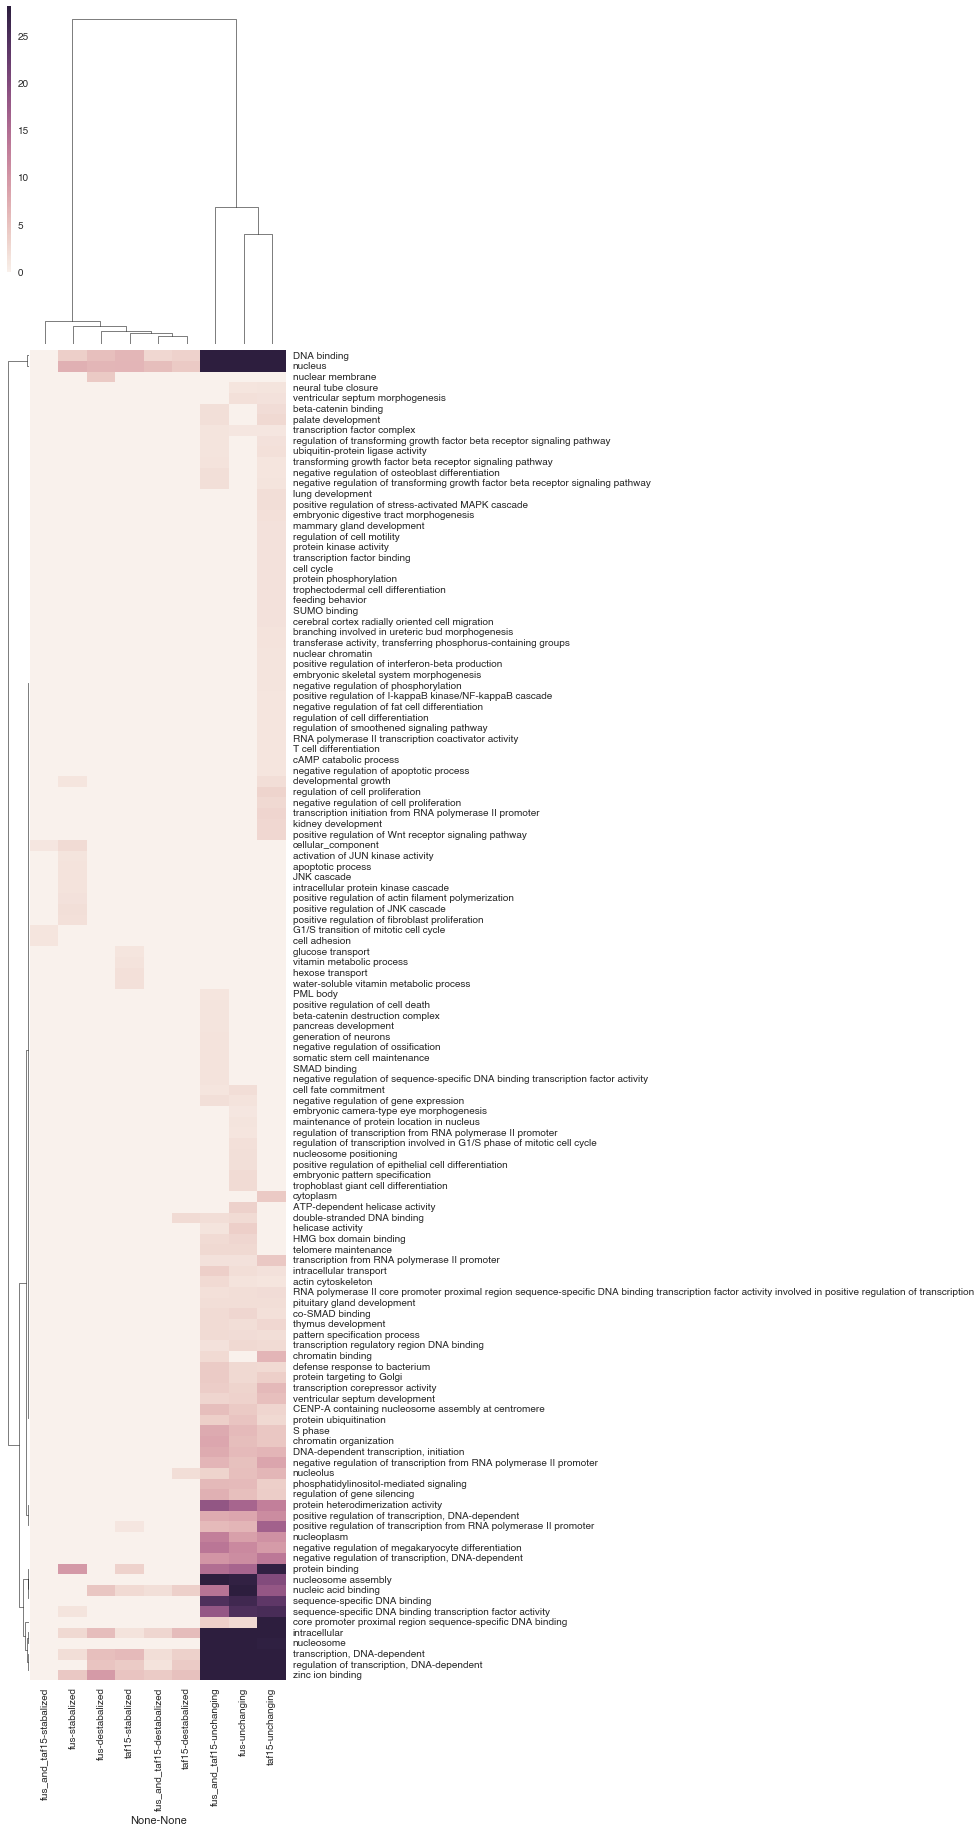

In [157]:
dataviz.plot_go_enrichment(changing_go_analysis, figsize=(5,30))

In [158]:
changing_go_analysis.ix['taf15']

GO Term Description  \
change       go_term_id                                                      
destabalized GO:0005622                                      intracellular   
             GO:0008270                                   zinc ion binding   
             GO:0005634                                            nucleus   
             GO:0006355         regulation of transcription, DNA-dependent   
             GO:0003676                               nucleic acid binding   
             GO:0006351                       transcription, DNA-dependent   
             GO:0003677                                        DNA binding   
             GO:0003690                        double-stranded DNA binding   
             GO:0005730                                          nucleolus   
stabalized   GO:0005634                                            nucleus   
             GO:0003677                                        DNA binding   
             GO:0006351                       transcription, DNA-dependent   
             GO:0008270                                   zinc ion binding   
             GO:0006355         regulation of transcription, DNA-dependent   
             GO:0005515                                    protein binding   
             GO:0003676                               nucleic acid binding   
             GO:0008645                                   hexose transport   
             GO:0006767            water-soluble vitamin metabolic process   
             GO:0006766                          vitamin metabolic process   
             GO:0005622                                      intracellular   
             GO:0015758                                  glucose transport   
             GO:0045944  positive regulation of transcription from RNA ...   
unchanging   GO:0000987  core promoter proximal region sequence-specifi...   
             GO:0003677                                        DNA binding   
             GO:0005634                                            nucleus   
             GO:0006351                       transcription, DNA-dependent   
             GO:0006355         regulation of transcription, DNA-dependent   
             GO:0008270                                   zinc ion binding   
             GO:0005622                                      intracellular   
             GO:0000786                                         nucleosome   
...                                                                    ...   
             GO:0021799   cerebral cortex radially oriented cell migration   
             GO:0007631                                   feeding behavior   
             GO:0001829               trophectodermal cell differentiation   
             GO:0032183                                       SUMO binding   
             GO:0006468                            protein phosphorylation   
             GO:0030879                          mammary gland development   
             GO:0060412                   ventricular septum morphogenesis   
             GO:0017015  regulation of transforming growth factor beta ...   
             GO:2000145                        regulation of cell motility   
             GO:0046907                            intracellular transport   
             GO:0001658   branching involved in ureteric bud morphogenesis   
             GO:0016772  transferase activity, transferring phosphorus-...   
             GO:0030512  negative regulation of transforming growth fac...   
             GO:0042326             negative regulation of phosphorylation   
             GO:0032728  positive regulation of interferon-beta production   
             GO:0048704            embryonic skeletal system morphogenesis   
             GO:0001843                                neural tube closure   
             GO:0000790                                  nuclear chromatin   
             GO:0043066           negative regulation of apoptotic process   

In [159]:
for name, df in changing_go_analysis.groupby(level=["rbp", 'change']):
    df.to_csv("/nas3/gpratt/Dropbox/TAF15_Manuscript/Tables/go_{}.csv".format("_".join(name)))

#Simulate Counts

By the plot below we asssume that the distriubtion of halflives is roughly expotental, I fit an exponental curve using a guess and check method to roughly model that and create a sample of artifical halflives I can attempt to model fit and experiment with

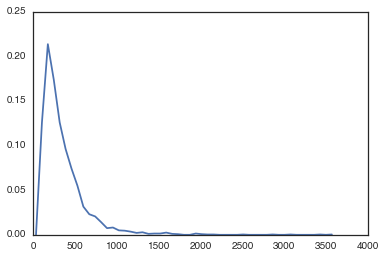

In [160]:
dataviz.plot_pdf(high_confidence_halflives.ix['FUS'].dropna())

In [161]:
artifical_halflives = scipy.random.exponential(scale=400, size=50000)

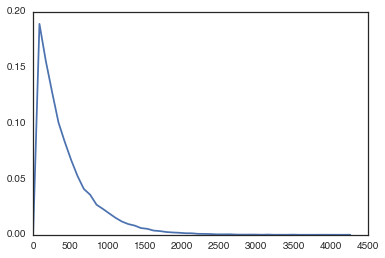

In [162]:
dataviz.plot_pdf(artifical_halflives)

I'll assume that the counts at t=0 are ground truth and start with a distribution roughly equal to that.  Then fit the decay model to the counts assuming a pseudo-spikein.

At each time point I will calculate the approrate amount of decay with some amount of assumed guassian noise.

Read counts can be modeled as a negative binomial distribution

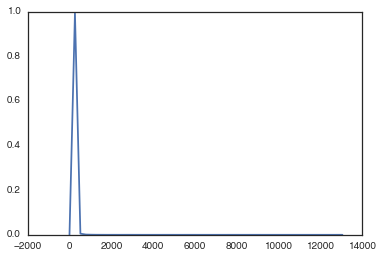

In [163]:
dataviz.plot_pdf(stabality_counts.NPC0_ctrl)

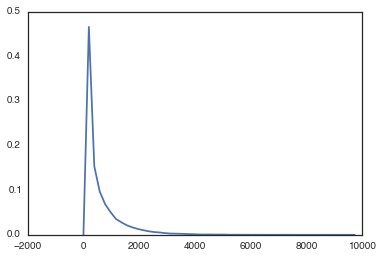

In [164]:
t_0_read_counts = dataviz.plot_pdf(scipy.random.negative_binomial(n=.5, p=.001, size=50000))

#5.	Identify if the regulated genes in the stability experiment are enriched for the proposed TAF15 binding motif.  If they are enriched specifically in the 3’ UTR or other regions.  This question was asked by both reviewer 1 and 3

Enriched means increased number of GGUAG motifs in a specific gene, relative to unrelated controls.  I plot this as two PDFs

In [165]:
#Get the enriched CDS, 5' UTRs, 3'UTRs from my annotations.  

In [166]:
import subprocess
import tempfile

In [167]:
foo = tempfile.NamedTemporaryFile()

In [168]:
foo.name

'/nas3/scratch/gpratt/pybedtools_tmp/tmpFr8fWe'

In [169]:
def annotatePeaks_stranded(peaks, motif, species="hg19", hist=10, size=1000):
    
    """
    
    runs homer with standard args
    output location is saved
    
    foreground - str, location of fasta file for the foreground distribution
    background - str, location of fasta file for the background distribution
    k - different k-mers to examine
    outloc - directory to output homer results 

    --make optional make work off locations and not fasta files 
    
    """
    #findMotifs.pl clusters.fa fasta outloc -nofacts p 4 -rna -S 10 -len 5,6,7,8,9 -noconvert -nogo -fasta background.fa
    #converts k to a string for use in subprocess
    #I'm forgetting strand specific information here
    with tempfile.NamedTemporaryFile() as out:
        try:
            subprocess.call(["annotatePeaks.pl",
                             peaks,
                             species,
                             "-m", motif,
                             #"-hist", str(hist),
                             "-size", "given",
                             "-noann"], shell=False, stdout=out)
        except OSError:
            print "Homer not installed, ignoring motif generation, install homer for this to work"  
            raise   
            
        print peaks, motif
        annotation = pd.read_table(out.name, index_col=0)
    annotation['stranded_peaks'] = annotation.apply(only_stranded_motifs, axis=1)
    return annotation

def only_stranded_motifs(row):
    motifs = row[-1]
    try:
        true_peaks = "),".join([motif for motif in motifs.split("),") if row.Strand in motif])
        if len(true_peaks) == 0:
            return np.nan
        
        return true_peaks
    except AttributeError:
        return motifs
    
def num_motifs(motifs):
    try:
        true_peaks = [motif for motif in motifs.split("),")]
        return len(true_peaks)
    except AttributeError:
        return 0

In [170]:
genomic_features = get_genomic_regions.GenomicFeatures("hg19")
genomic_regions = genomic_features.get_genomic_regions()

foo


In [171]:
filtered_regions = defaultdict(dict)
for region in genomic_regions:
    filtered_regions[region]["destabalized"] = genomic_regions[region].filter(lambda x: x.name in taf15_destabalized).saveas("taf15_destabalized_{}.bed".format(region))
    filtered_regions[region]["unchanging"] = genomic_regions[region].filter(lambda x: x.name in taf15_unchanging).saveas("taf15_unchanging_{}.bed".format(region))
    filtered_regions[region]["stabalized"] = genomic_regions[region].filter(lambda x: x.name in taf15_stabalized).saveas("taf15_stabalized_{}.bed".format(region))
    
fus_filtered_regions = defaultdict(dict)
for region in genomic_regions:
    fus_filtered_regions[region]["destabalized"] = genomic_regions[region].filter(lambda x: x.name in fus_destabalized).saveas("fus_destabalized_{}.bed".format(region))
    fus_filtered_regions[region]["unchanging"] = genomic_regions[region].filter(lambda x: x.name in fus_unchanging).saveas("fus_unchanging_{}.bed".format(region))
    fus_filtered_regions[region]["stabalized"] = genomic_regions[region].filter(lambda x: x.name in fus_stabalized).saveas("fus_stabalized_{}.bed".format(region))

In [172]:
def get_motifs_in_regions(regions, motif):
    motifs_in_regions = defaultdict(dict)
    for region in regions:
        motifs_in_regions[region]["destabalized"] = annotatePeaks_stranded(filtered_regions[region]['destabalized'].fn, motif)
        motifs_in_regions[region]["unchanging"] = annotatePeaks_stranded(filtered_regions[region]['unchanging'].fn, motif)
        motifs_in_regions[region]["stabalized"] = annotatePeaks_stranded(filtered_regions[region]['stabalized'].fn, motif)

        motifs_in_regions[region]["destabalized"]['num_motifs'] = motifs_in_regions[region]["destabalized"].stranded_peaks.apply(num_motifs)
        motifs_in_regions[region]["destabalized"]['gene_id'] = motifs_in_regions[region]["destabalized"].index.map(lambda x: x.split("-")[0])

        motifs_in_regions[region]["unchanging"]['num_motifs'] = motifs_in_regions[region]["unchanging"].stranded_peaks.apply(num_motifs)
        motifs_in_regions[region]["unchanging"]['gene_id'] = motifs_in_regions[region]["unchanging"].index.map(lambda x: x.split("-")[0])

        motifs_in_regions[region]["stabalized"]['num_motifs'] = motifs_in_regions[region]["stabalized"].stranded_peaks.apply(num_motifs)
        motifs_in_regions[region]["stabalized"]['gene_id'] = motifs_in_regions[region]["stabalized"].index.map(lambda x: x.split("-")[0])
    return motifs_in_regions

motifs_in_regions = get_motifs_in_regions(filtered_regions, "gguag.motif")
fus_motifs_in_regions = get_motifs_in_regions(filtered_regions, "gugg.motif")
taf15_long_motifs_in_regions = get_motifs_in_regions(filtered_regions, "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.motif")

taf15_destabalized_three_prime_utrs.bed gguag.motif
taf15_unchanging_three_prime_utrs.bed gguag.motif
taf15_stabalized_three_prime_utrs.bed gguag.motif
taf15_destabalized_five_prime_utrs.bed gguag.motif
taf15_unchanging_five_prime_utrs.bed gguag.motif
taf15_stabalized_five_prime_utrs.bed gguag.motif
taf15_destabalized_exons.bed gguag.motif
taf15_unchanging_exons.bed gguag.motif
taf15_stabalized_exons.bed gguag.motif
taf15_destabalized_proxintron.bed gguag.motif
taf15_unchanging_proxintron.bed gguag.motif
taf15_stabalized_proxintron.bed gguag.motif
taf15_destabalized_genes.bed gguag.motif
taf15_unchanging_genes.bed gguag.motif
taf15_stabalized_genes.bed gguag.motif
taf15_destabalized_introns.bed gguag.motif
taf15_unchanging_introns.bed gguag.motif
taf15_stabalized_introns.bed gguag.motif
taf15_destabalized_distintron.bed gguag.motif
taf15_unchanging_distintron.bed gguag.motif
taf15_stabalized_distintron.bed gguag.motif
taf15_destabalized_cds.bed gguag.motif
taf15_unchanging_cds.bed ggua

In [184]:
regions_name_dict, foo = CLIP_analysis.regions_generator()

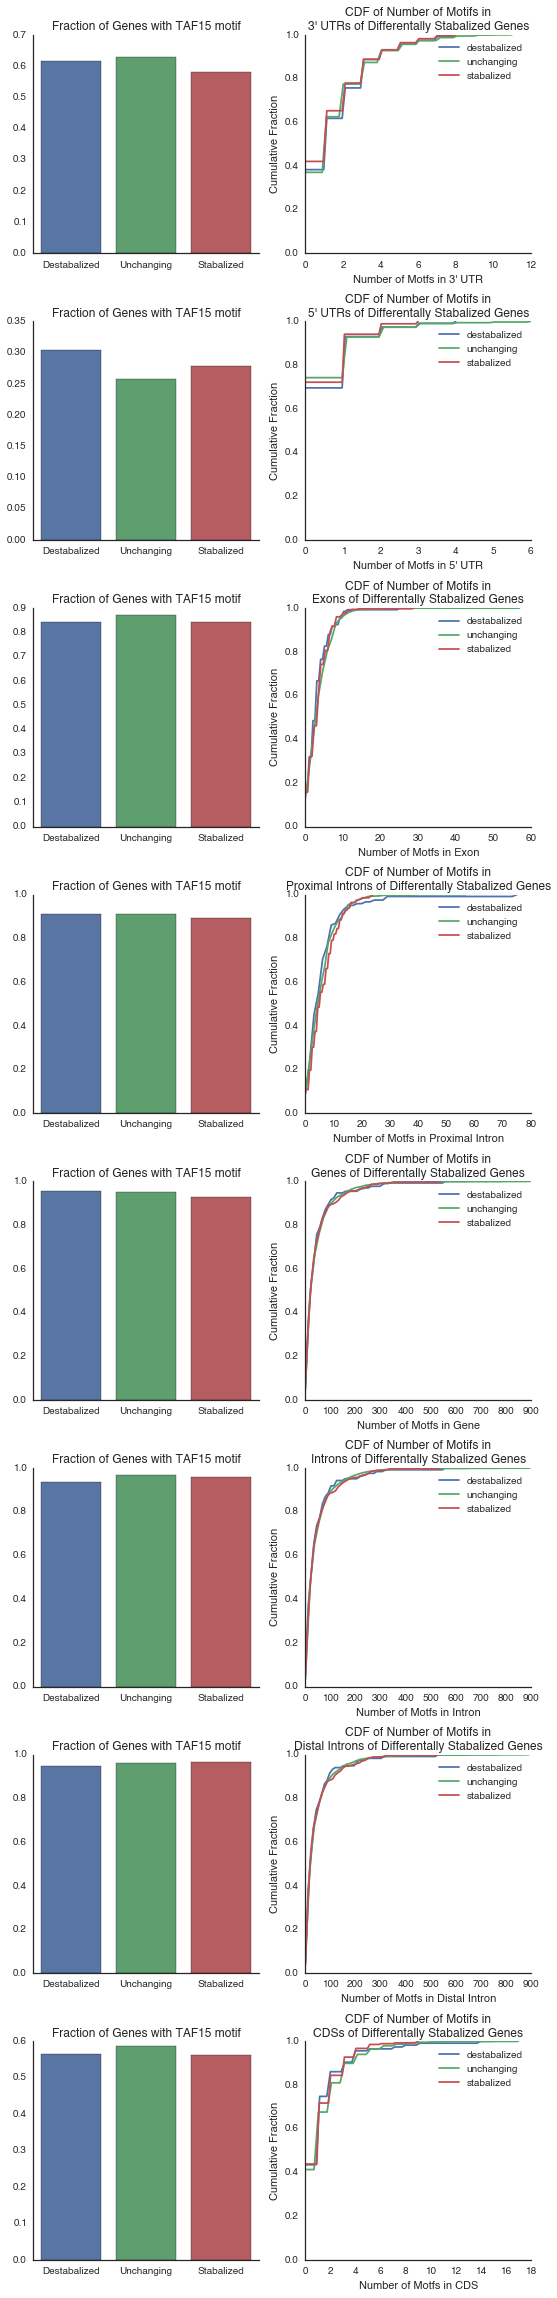

In [174]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "taf15_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in motifs_in_regions:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        destabalized = motifs_in_regions[region]["destabalized"].groupby("gene_id").sum()
        unchanging = motifs_in_regions[region]["unchanging"].groupby("gene_id").sum()
        stabalized = motifs_in_regions[region]["stabalized"].groupby("gene_id").sum()

        sns.barplot(["Destabalized", "Unchanging", "Stabalized"], 
                    [len(destabalized[destabalized.num_motifs != 0]) /  (len(destabalized) * 1.0),
                     len(unchanging[unchanging.num_motifs != 0]) /  (len(unchanging) * 1.0),
                     len(stabalized[stabalized.num_motifs != 0]) /  (len(stabalized) * 1.0),
                    ],
                   ax=ax)
        sns.despine(ax=ax)
        ax.set_title("Fraction of Genes with TAF15 motif")

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(destabalized.num_motifs, label="destabalized", ax=ax)
        dataviz.plot_cdf(unchanging.num_motifs, label="unchanging", ax=ax)
        dataviz.plot_cdf(stabalized.num_motifs, label="stabalized", ax=ax)
        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(regions_name_dict[region]))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{}s of Differentally Stabalized Genes".format(regions_name_dict[region]))
        sns.despine(ax=ax)

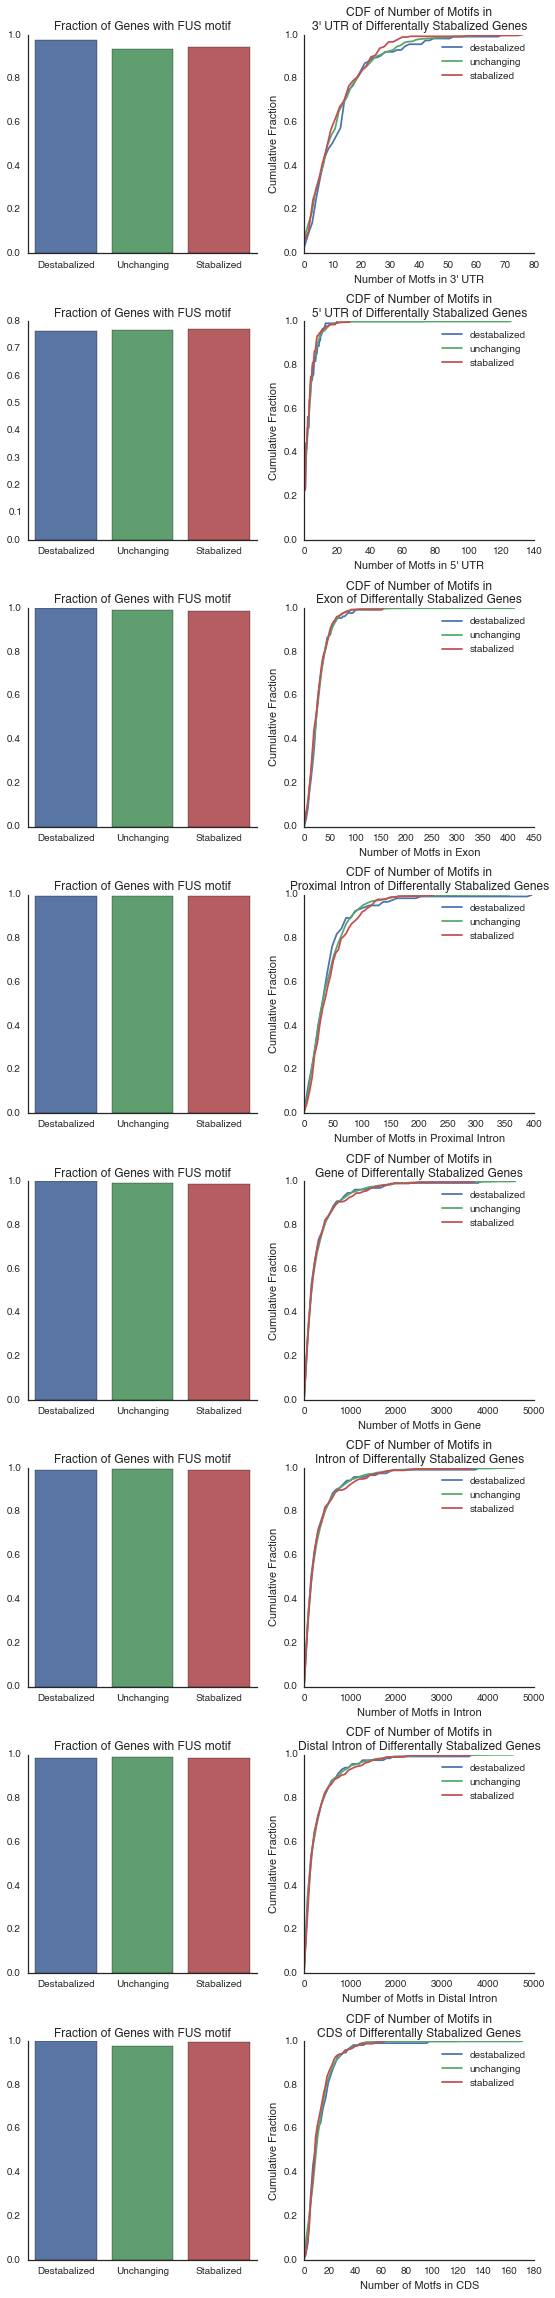

In [175]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "fus_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in motifs_in_regions:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        destabalized = fus_motifs_in_regions[region]["destabalized"].groupby("gene_id").sum()
        unchanging = fus_motifs_in_regions[region]["unchanging"].groupby("gene_id").sum()
        stabalized = fus_motifs_in_regions[region]["stabalized"].groupby("gene_id").sum()

        sns.barplot(["Destabalized", "Unchanging", "Stabalized"], 
                    [len(destabalized[destabalized.num_motifs != 0]) /  (len(destabalized) * 1.0),
                     len(unchanging[unchanging.num_motifs != 0]) /  (len(unchanging) * 1.0),
                     len(stabalized[stabalized.num_motifs != 0]) /  (len(stabalized) * 1.0),
                    ],
                   ax=ax)
        sns.despine(ax=ax)
        ax.set_title("Fraction of Genes with FUS motif")

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(destabalized.num_motifs, label="destabalized", ax=ax)
        dataviz.plot_cdf(unchanging.num_motifs, label="unchanging", ax=ax)
        dataviz.plot_cdf(stabalized.num_motifs, label="stabalized", ax=ax)
        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(regions_name_dict[region]))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{} of Differentally Stabalized Genes".format(regions_name_dict[region]))
        sns.despine(ax=ax)

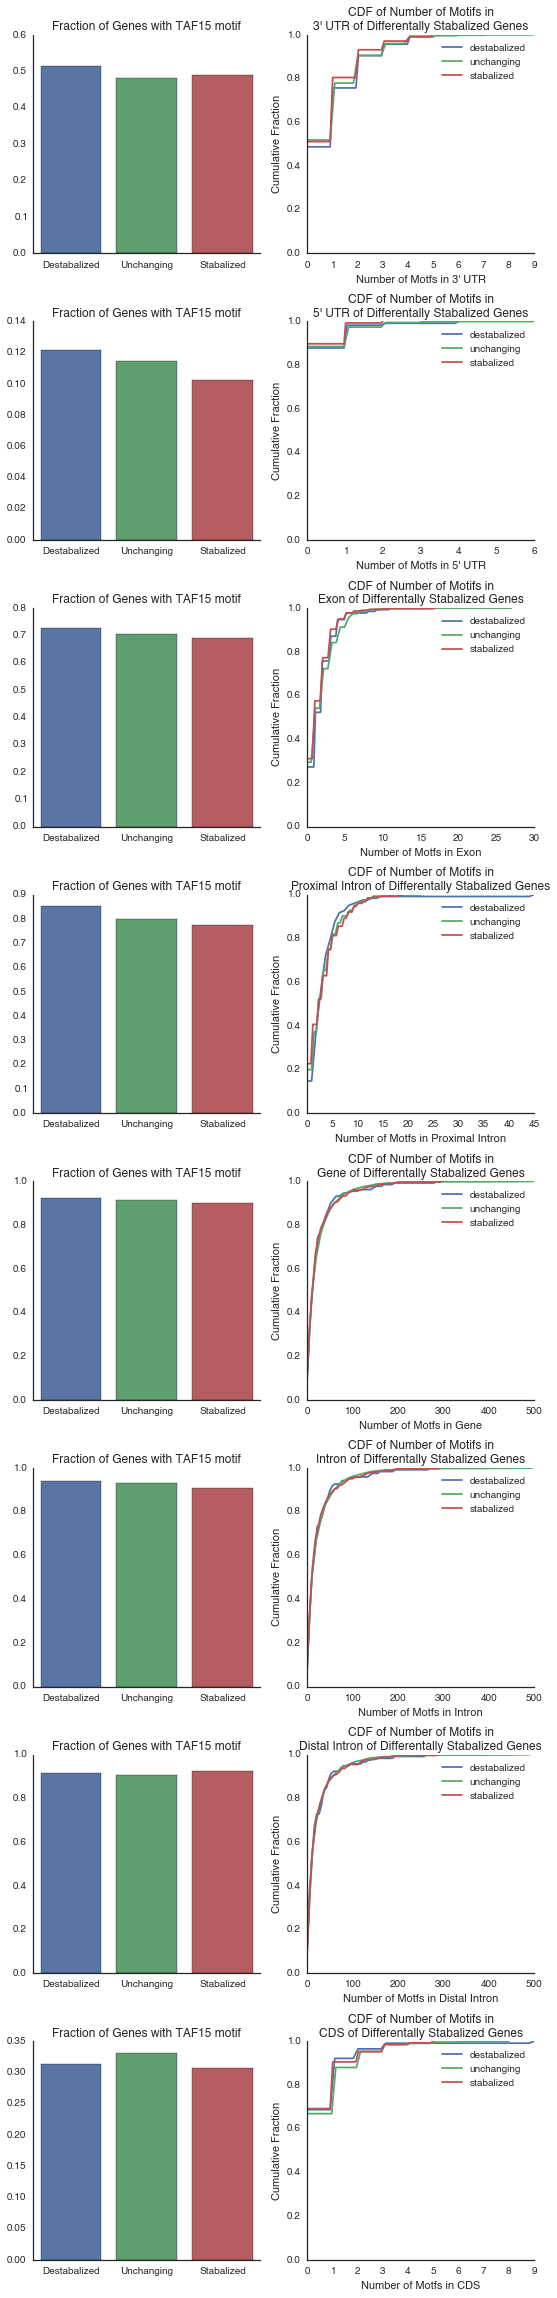

In [176]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "taf15_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in motifs_in_regions:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        destabalized = taf15_long_motifs_in_regions[region]["destabalized"].groupby("gene_id").sum()
        unchanging = taf15_long_motifs_in_regions[region]["unchanging"].groupby("gene_id").sum()
        stabalized = taf15_long_motifs_in_regions[region]["stabalized"].groupby("gene_id").sum()

        sns.barplot(["Destabalized", "Unchanging", "Stabalized"], 
                    [len(destabalized[destabalized.num_motifs != 0]) /  (len(destabalized) * 1.0),
                     len(unchanging[unchanging.num_motifs != 0]) /  (len(unchanging) * 1.0),
                     len(stabalized[stabalized.num_motifs != 0]) /  (len(stabalized) * 1.0),
                    ],
                   ax=ax)
        sns.despine(ax=ax)
        ax.set_title("Fraction of Genes with TAF15 motif")

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(destabalized.num_motifs, label="destabalized", ax=ax)
        dataviz.plot_cdf(unchanging.num_motifs, label="unchanging", ax=ax)
        dataviz.plot_cdf(stabalized.num_motifs, label="stabalized", ax=ax)
        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(regions_name_dict[region]))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{} of Differentally Stabalized Genes".format(regions_name_dict[region]))
        sns.despine(ax=ax)

NameError: name 'region_name_dict' is not defined

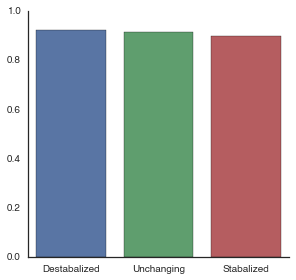

In [177]:
num_rows = 1
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "taf15_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in ['genes', 'three_prime_utrs']:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        destabalized = taf15_long_motifs_in_regions[region]["destabalized"].groupby("gene_id").sum()
        unchanging = taf15_long_motifs_in_regions[region]["unchanging"].groupby("gene_id").sum()
        stabalized = taf15_long_motifs_in_regions[region]["stabalized"].groupby("gene_id").sum()

        sns.barplot(["Destabalized", "Unchanging", "Stabalized"], 
                    [len(destabalized[destabalized.num_motifs != 0]) /  (len(destabalized) * 1.0),
                     len(unchanging[unchanging.num_motifs != 0]) /  (len(unchanging) * 1.0),
                     len(stabalized[stabalized.num_motifs != 0]) /  (len(stabalized) * 1.0),
                    ],
                   ax=ax)
        ax.set_ylim(0,1)
        sns.despine(ax=ax)
        ax.set_title("Fraction of {}\n with TAF15 Motif".format(region_name_dict[region]))

In [ ]:
num_rows = 1
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "fus_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in ['genes', 'three_prime_utrs']:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        destabalized = fus_motifs_in_regions[region]["destabalized"].groupby("gene_id").sum()
        unchanging = fus_motifs_in_regions[region]["unchanging"].groupby("gene_id").sum()
        stabalized = fus_motifs_in_regions[region]["stabalized"].groupby("gene_id").sum()

        sns.barplot(["Destabalized", "Unchanging", "Stabalized"], 
                    [len(destabalized[destabalized.num_motifs != 0]) /  (len(destabalized) * 1.0),
                     len(unchanging[unchanging.num_motifs != 0]) /  (len(unchanging) * 1.0),
                     len(stabalized[stabalized.num_motifs != 0]) /  (len(stabalized) * 1.0),
                    ],
                   ax=ax)
        ax.set_ylim(0,1)
        sns.despine(ax=ax)
        ax.set_title("Fraction of \n{} with FUS Motif".format(region_name_dict[region]))
    

In [ ]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "fus_motif_frequency_important_regions.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in ['genes', 'three_prime_utrs']:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        destabalized = fus_motifs_in_regions[region]["destabalized"].groupby("gene_id").sum()
        unchanging = fus_motifs_in_regions[region]["unchanging"].groupby("gene_id").sum()
        stabalized = fus_motifs_in_regions[region]["stabalized"].groupby("gene_id").sum()

        sns.barplot(["Destabalized", "Unchanging", "Stabalized"], 
                    [len(destabalized[destabalized.num_motifs != 0]) /  (len(destabalized) * 1.0),
                     len(unchanging[unchanging.num_motifs != 0]) /  (len(unchanging) * 1.0),
                     len(stabalized[stabalized.num_motifs != 0]) /  (len(stabalized) * 1.0),
                    ],
                   ax=ax)
        sns.despine(ax=ax)
        ax.set_title("Fraction of {}s with FUS motif".format(regions_name_dict[region]))

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(destabalized.num_motifs, label="destabalized", ax=ax)
        dataviz.plot_cdf(unchanging.num_motifs, label="unchanging", ax=ax)
        dataviz.plot_cdf(stabalized.num_motifs, label="stabalized", ax=ax)
        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(regions_name_dict[region]))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{} of Differentally Stabalized Genes".format(regions_name_dict[region]))
        sns.despine(ax=ax)

#Do Genes bound in mouse brain predict stabality differences in human NPCs?

In [ ]:
def map_to_human(genes):
    for gene in genes:
        try:
            gene = gene.split(".")[0]
            gene =  mouse_human_genes_dict[gene]
        except KeyError:
            gene = np.nan
        yield gene
        
def map_to_name(genes):
    for gene in genes:
        try:
            gene =  ensembl_to_name[gene]
        except:
            gene = "error"
        yield gene

In [ ]:
binding_df_df = pd.DataFrame(binding_df)
binding_df_df['human_genes'] = list(map_to_human(binding_df.index.get_level_values(level=2)))

In [ ]:
taf15_destabalized_binding_df = binding_df_df[binding_df_df.human_genes.isin([gene.split(".")[0] for gene in taf15_destabalized.index])]
taf15_unchanging_binding_df = binding_df_df[binding_df_df.human_genes.isin([gene.split(".")[0] for gene in taf15_unchanging.index])]
taf15_stabalized_binding_df = binding_df_df[binding_df_df.human_genes.isin([gene.split(".")[0] for gene in taf15_stabalized.index])]

fus_destabalized_binding_df = binding_df_df[binding_df_df.human_genes.isin([gene.split(".")[0] for gene in fus_destabalized.index])]
fus_unchanging_binding_df = binding_df_df[binding_df_df.human_genes.isin([gene.split(".")[0] for gene in fus_unchanging.index])]
fus_stabalized_binding_df = binding_df_df[binding_df_df.human_genes.isin([gene.split(".")[0] for gene in fus_stabalized.index])]


In [ ]:
pd.concat({"destabalized": (taf15_destabalized_binding_df.groupby(level=['rbp', 'region']).count() / len(taf15_destabalized)).human_genes, 
"unchanging": (taf15_unchanging_binding_df.groupby(level=['rbp', 'region']).count() / len(taf15_unchanging)).human_genes ,
"stabalized": (taf15_stabalized_binding_df.groupby(level=['rbp', 'region']).count() / len(taf15_stabalized)).human_genes},).xs("taf15", level="rbp").unstack()

In [ ]:
pd.concat({"destabalized": (fus_destabalized_binding_df.groupby(level=['rbp', 'region']).count() / len(fus_destabalized)).human_genes ,
"unchanging": (fus_unchanging_binding_df.groupby(level=['rbp', 'region']).count() / len(fus_unchanging)).human_genes ,
"stabalized": (fus_stabalized_binding_df.groupby(level=['rbp', 'region']).count() / len(fus_stabalized)).human_genes ,}).xs("fus", level="rbp").unstack()

#Exon Size Analysis

In [178]:
genomic_features = get_genomic_regions.GenomicFeatures("hg19")
genomic_regions = genomic_features.get_genomic_regions()

foo


In [179]:
all_intron_information = pd.concat({"fus_destabalized": genomic_regions["introns"].filter(lambda x: x.name in fus_destabalized.index).saveas().to_dataframe(),
                                    "fus_unchanging": genomic_regions["introns"].filter(lambda x: x.name in fus_unchanging.index).saveas().to_dataframe(),
                                    "fus_stabalized": genomic_regions["introns"].filter(lambda x: x.name in fus_stabalized.index).saveas().to_dataframe(),
                                    "taf15_destabalized": genomic_regions["introns"].filter(lambda x: x.name in taf15_destabalized.index).saveas().to_dataframe(),
                                    "taf15_unchanging": genomic_regions["introns"].filter(lambda x: x.name in taf15_unchanging.index).saveas().to_dataframe(),
                                    "taf15_stabalized": genomic_regions["introns"].filter(lambda x: x.name in taf15_stabalized.index).saveas().to_dataframe(),},
                                  names=['condition', 'intron_id'])

all_intron_information['intron_length'] = all_intron_information.end - all_intron_information.start 
all_intron_information['condition'] = all_intron_information.index.get_level_values(level=0)

In [180]:
all_intron_information.groupby("condition").mean()

start           end  score  intron_length
condition                                                           
fus_destabalized    1.103524e+08  1.103602e+08      0    7863.387952
fus_stabalized      8.106131e+07  8.107115e+07      0    9845.685275
fus_unchanging      7.967888e+07  7.968785e+07      0    8966.344193
taf15_destabalized  8.833553e+07  8.834412e+07      0    8591.657199
taf15_stabalized    8.134981e+07  8.135872e+07      0    8909.814863
taf15_unchanging    7.698220e+07  7.699073e+07      0    8530.361458

In [187]:
all_intron_information['rbp'] = all_intron_information.condition.apply(lambda x: x.split("_")[0])
all_intron_information['direction'] = all_intron_information.condition.apply(lambda x: x.split("_")[1])

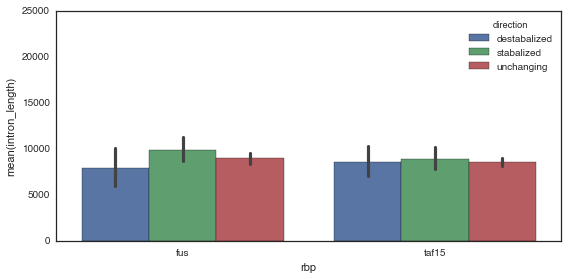

In [189]:
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "taf15_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.barplot(data=all_intron_information, x="rbp", y="intron_length", hue="direction", ax=ax)
    ax.set_ylim(0, 25000)